In [1]:
from os import listdir
from os.path import isfile, join
# from Utils import Load, Write
import pandas as pd
import numpy as np
from scipy import stats
import math
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import cm
# import plotly.plotly as py
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
from pop_calcs import *
from pop_organize import *
from skbio.diversity.alpha import shannon, simpson, berger_parker_d
import time
import seaborn as sns

In [3]:
def get_sample_with_dfs():
    print 'getting list of samples that have dfs...'
    df_file_names = [f for f in listdir("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles") if isfile(join("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles", f))]
    df_file_names = [df_file for df_file in df_file_names if df_file.startswith ('sample_df_HIP')]
    samples_with_df=[s.replace("sample_df_", "") for s in df_file_names]
    print 'finished getting list of samples that have dfs'
    return df_file_names,samples_with_df


In [4]:
df_file_names,samples_with_df=get_sample_with_dfs()

getting list of samples that have dfs...
finished getting list of samples that have dfs


In [582]:
'HIP01391' in samples_with_df

True

In [347]:


#########################
#    main function      #
#########################

##generate list of sample file names:
onlyfiles = [f for f in listdir("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/CSVfiles") if isfile(join("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/CSVfiles", f))]
onlyfiles = [datafile for datafile in onlyfiles if datafile.startswith ('HIP') and datafile.endswith('.csv')]
sample_names=[re.sub('.csv', '', datafile) for datafile in onlyfiles] ## generate list of 
                                                                      ## sample names out 
                                                                      ##of the sample file names
df_file_names,samples_with_df=get_sample_with_dfs() ## check which samples have df
generate_dfs=False ##False=load them from pickles, True=generate them. 

df_n=2 ## define number of dfs (prod, non-prod) *** check for update!***

getting list of samples that have dfs...
finished getting list of samples that have dfs


In [348]:
percProd_func_list=[perc_prod]

In [349]:
general_function_list=[unique_seq_n, unique_aa_n,norm_uniqe_nt_sequences, norm_uniqe_aa_sequences, max_nt_per_aa,mean_nt_per_aa, gc_content] 

In [396]:
clonality_func_list=[top_clonal_nt, top_1000clons_nt, Percentile1_clone_nt, median_clone_nt, Percentile999_clone_nt, mean_clonal_nt, std_clonal_nt, top_clonal_aa, top_1000clons_aa, Percentile1_clone_aa, median_clone_aa, Percentile999_clone_aa, mean_clonal_aa, std_clonal_aa]

In [527]:
diversity_func_list=[shannon_div_nt, simpson_div_nt, bpi_div_nt, shannon_div_aa, simpson_div_aa, bpi_div_aa]

In [555]:
length_func_list=[mean_cdr3, sv_cdr3, mean_vDeletion, sv_vDeletion, mean_n1Insertion, sv_n1Insertion, mean_d5Deletion, sv_d5Deletion, 
                  mean_d3Deletion, sv_d3Deletion, mean_n2Insertion, sv_n2Insertion, mean_jDeletion, sv_jDeletion]

In [ ]:
def generate_res_DF(sample_names, function_list, df_n):
    print 'generating result dataframe...'
    result_df=pd.DataFrame({'Sample': sample_names})
    result_df=result_df.set_index('Sample')
    function_names=[f.__name__ for f in function_list]
    for function in function_names:
        for i in range(df_n):
            col_title=function+'_df_%s' %str(i)
            result_df[col_title]=np.NaN
    print 'finished generating result dataframe'
    return result_df


In [325]:
perProd_res_df=generate_res_DF(samples_with_df, percProd_func_list, 1)

generating result dataframe...
finished generating result dataframe


In [326]:
general_res_df=generate_res_DF(samples_with_df, general_function_list, df_n)

generating result dataframe...
finished generating result dataframe


In [352]:
clonality_res_df=generate_res_DF(samples_with_df, clonality_func_list, df_n)

generating result dataframe...
finished generating result dataframe


In [535]:
diversity_res_df=generate_res_DF(samples_with_df, diversity_func_list, df_n)

generating result dataframe...
finished generating result dataframe


In [535]:
length_res_df=generate_res_DF(samples_with_df, length_func_list, df_n)

generating result dataframe...
finished generating result dataframe


In [5]:
def get_sample_data(sample_name, generate_dfs): 
## this function generates dfs (general, only productive and only non productive) for each sample, and save
## as pickles. alternatively, it loads these dfs from pickles. 
    
    print 'getting sample data...'
    
    if generate_dfs:
        sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name)  
        sample_df_prod = sample_df[sample_df['sequenceStatus'] == 'In']
        sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']
        
        pickle.dump(sample_df, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_%s' %sample_name, "wb"))
        pickle.dump(sample_df_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_%s' %sample_name, "wb"))
        pickle.dump(sample_df_non_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_%s' %sample_name, "wb"))
    else:
        sample_df= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_%s' %sample_name,"rb" ))
        sample_df_prod= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_%s' %sample_name,"rb" ))
        sample_df_non_prod= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_%s' %sample_name,"rb" ))
    
    print 'finished getting sample data'
    return sample_df, sample_df_prod, sample_df_non_prod

#_________________________________________________________________

In [354]:
def perc_prod(full_df):
    sample_prod = full_df.groupby(['sequenceStatus'])[['frequencyCount (%)']].sum()
    perc_prod=list(sample_prod['frequencyCount (%)'])[0]
    return perc_prod


In [355]:
## general functions:


def unique_seq_n(df, **kwargs): 
    n_seqs=len(list(df['nucleotide']))
    return n_seqs

def unique_aa_n(df, **kwargs):
    list_aa=list(df['aminoAcid'])
    list_aa_new=[i for i in list_aa if isinstance(i, str)]
    n_seq_aa=len(set(list_aa_new))
    return n_seq_aa

def max_nt_per_aa(df, **kwargs):
    nt_per_aa = df.groupby(['aminoAcid'])[['nucleotide']].count()
    max_nt_per_aa=max(nt_per_aa['nucleotide'])
    return max_nt_per_aa

def mean_nt_per_aa(df, **kwargs):
    nt_per_aa = df.groupby(['aminoAcid'])[['nucleotide']].count()
    mean_nt_per_aa=round(np.mean(nt_per_aa['nucleotide']),3)
    return mean_nt_per_aa


In [356]:
## general functions:


def norm_uniqe_nt_sequences(df, **kwargs): 
repeats=10
samp_size=100000
reads=list(df['count (reads)'])
df=df.set_index('nucleotide')
seqs=[str(i) for i in list(df.index)]
seq_popped=[]
for i in range(0,len(seqs)):
    for j in range(0,reads[i]):
        seq_popped.append(seqs[i])        
seq_n_list=[]
for t in range(repeats):
    rand_seq=np.random.choice(seq_popped, samp_size, replace=False)
    seq_n=len(set(rand_seq))
    seq_n_list.append(seq_n)
    mean_seq_n=np.mean(seq_n_list)
return mean_seq_n         


In [357]:
## general functions:

def norm_uniqe_aa_sequences(df, **kwargs): 
    repeats=10
    samp_size=5000
    reads=list(df['count (reads)'])
    list_aa=list(df['aminoAcid'])  
    seq_aa_popped=[]
    for i in range(0,len(list_aa)):
        for j in range(0,reads[i]):
            seq_aa_popped.append(list_aa[i])
    seq_aa_popped_new=[i for i in seq_aa_popped if isinstance(i, str)]
    seq_n_list=[]
    if len(seq_aa_popped_new)>samp_size:
        for t in range(repeats):
            rand_seq=np.random.choice(seq_aa_popped_new, samp_size, replace=False)
            seq_n=len(set(rand_seq))
            seq_n_list.append(seq_n)
        mean_seq_n=np.mean(seq_n_list)
    else:
        mean_seq_n=np.NaN
    return mean_seq_n         


In [358]:
## general functions:

def gc_content(df, **kwargs):
    seqs=list(df['nucleotide'])
    gc_values = [GC(seq) for seq in seqs]
    mean_gc=np.mean(gc_values)
    return mean_gc

In [397]:
##clonality functions:

def gen_clonality_list_nt(df):
    clonality_list=list(df['frequencyCount (%)'])
    clonality_total=sum(clonality_list)
    normed_clonality_list=[i/clonality_total for i in clonality_list]
    sorted_clonality_list_nt=sorted(normed_clonality_list, reverse=True)
    return sorted_clonality_list_nt

def top_clonal_nt(df):
    sorted_clon_list_nt=gen_clonality_list_nt(df)
    top_clone_freq=sorted_clon_list_nt[0]
    return  top_clone_freq

def top_1000clons_nt(df):
    sorted_clon_list_nt=gen_clonality_list_nt(df)
    top1000fract=0
    for i in range(1000):
        top1000fract+=sorted_clon_list_nt[i]
    return top1000fract

def Percentile1_clone_nt(df):
    sorted_clon_list_nt=gen_clonality_list_nt(df)
    perc1=np.percentile(sorted_clon_list_nt,1)
    return perc1

def median_clone_nt(df):
    sorted_clon_list_nt=gen_clonality_list_nt(df)
    median_clone=np.percentile(sorted_clon_list_nt,50)
    return median_clone

def Percentile999_clone_nt(df):
    sorted_clon_list_nt=gen_clonality_list_nt(df)
    perc999=np.percentile(sorted_clon_list_nt,99.9)
    return perc999

def mean_clonal_nt(df):
    sorted_clon_list_nt=gen_clonality_list_nt(df)
    mean_clonal=np.mean(sorted_clon_list_nt)
    return mean_clonal

def std_clonal_nt(df):
    sorted_clon_list_nt=gen_clonality_list_nt(df)
    std_clonal=np.std(sorted_clon_list_nt)
    return std_clonal

    
    
    

hello


In [395]:
##clonality functions:

def gen_clonality_list_aa(df):
    aa_freqs = df.groupby(['aminoAcid'])[['frequencyCount (%)']].sum()
    aa_freq_list=list(aa_freqs['frequencyCount (%)'])  
    aa_freq_total=sum(aa_freq_list)
    normed_clonality_list_aa=[i/aa_freq_total for i in aa_freq_list]
    sorted_clonality_list_aa=sorted(normed_clonality_list_aa, reverse=True)
    return sorted_clonality_list_aa

def top_clonal_aa(df):
    sorted_clon_list_aa=gen_clonality_list_aa(df)
    top_clone_freq=sorted_clon_list_aa[0]
    return  top_clone_freq

def top_1000clons_aa(df):
    sorted_clon_list_aa=gen_clonality_list_aa(df)
    if len(sorted_clon_list_aa)>1000:
        top1000fract=0
        for i in range(1000):
            top1000fract+=sorted_clon_list_aa[i]
    else:
        top1000fract=1.0
    return top1000fract

def Percentile1_clone_aa(df):
    sorted_clon_list_aa=gen_clonality_list_aa(df)
    perc1=np.percentile(sorted_clon_list_aa,1)
    return perc1

def median_clone_aa(df):
    sorted_clon_list_aa=gen_clonality_list_aa(df)
    median_clone=np.percentile(sorted_clon_list_aa,50)
    return median_clone

def Percentile999_clone_aa(df):
    sorted_clon_list_aa=gen_clonality_list_aa(df)
    perc999=np.percentile(sorted_clon_list_aa,99.9)
    return perc999

def mean_clonal_aa(df):
    sorted_clon_list_aa=gen_clonality_list_aa(df)
    mean_clonal=np.mean(sorted_clon_list_aa)
    return mean_clonal

def std_clonal_aa(df):
    sorted_clon_list_aa=gen_clonality_list_aa(df)
    std_clonal=np.std(sorted_clon_list_aa)
    return std_clonal
      
    
    

In [529]:
## diversity functions:

def shannon_div_nt(df):
    read_counts=list(df['count (reads)'])
    H=shannon(read_counts, base=2)
    return H

def simpson_div_nt(df):
    read_counts=list(df['count (reads)'])
    D=simpson(read_counts)
    return D

def bpi_div_nt(df):
    read_counts=list(df['count (reads)'])
    D=berger_parker_d(read_counts)
    return D

def shannon_div_aa(df):
    aa_reads = df.groupby(['aminoAcid'])[['count (reads)']].sum()
    read_counts=list(aa_reads['count (reads)']) 
    H=shannon(read_counts, base=2)
    return H

def simpson_div_aa(df):
    aa_reads = df.groupby(['aminoAcid'])[['count (reads)']].sum()
    read_counts=list(aa_reads['count (reads)']) 
    D=simpson(read_counts)
    return D

def bpi_div_aa(df):
    aa_reads = df.groupby(['aminoAcid'])[['count (reads)']].sum()
    read_counts=list(aa_reads['count (reads)']) 
    D=berger_parker_d(read_counts)
    return D
    

In [554]:
##length functions: 


def mean_cdr3(df):
    mean_cdr3=np.mean(df['cdr3Length'])
    return mean_cdr3

def sv_cdr3(df):
    sv_cdr3=np.std(df['cdr3Length'])/np.mean(df['cdr3Length'])
    return sv_cdr3

def mean_vDeletion(df):
    mean_vDeletion=np.mean(df['vDeletion'])
    return mean_vDeletion

def sv_vDeletion(df):
    sv_vDeletion=np.std(df['vDeletion'])/np.mean(df['vDeletion'])
    return sv_vDeletion

def mean_n1Insertion(df):
    mean_n1Insertion=np.mean(df['n1Insertion'])
    return mean_n1Insertion

def sv_n1Insertion(df):
    sv_n1Insertion=np.std(df['n1Insertion'])/np.mean(df['n1Insertion'])
    return sv_n1Insertion

def mean_d5Deletion(df):
    mean_d5Deletion=np.mean(df['d5Deletion'])
    return mean_d5Deletion

def sv_d5Deletion(df):
    sv_d5Deletion=np.std(df['d5Deletion'])/np.mean(df['d5Deletion'])
    return sv_d5Deletion

def mean_d3Deletion(df):
    mean_d3Deletion=np.mean(df['d3Deletion'])
    return mean_d3Deletion

def sv_d3Deletion(df):
    sv_d3Deletion=np.std(df['d3Deletion'])/np.mean(df['d3Deletion'])
    return sv_d3Deletion

def mean_n2Insertion(df):
    mean_n2Insertion=np.mean(df['n2Insertion'])
    return mean_n2Insertion

def sv_n2Insertion(df):
    sv_n2Insertion=np.std(df['n2Insertion'])/np.mean(df['n2Insertion'])
    return sv_n2Insertion

def mean_jDeletion(df):
    mean_jDeletion=np.mean(df['jDeletion'])
    return mean_jDeletion

def sv_jDeletion(df):
    sv_jDeletion=np.std(df['jDeletion'])/np.mean(df['jDeletion'])
    return sv_jDeletion


In [530]:
def calculate_res_df(result_df,function_list, sample_name, sample_df_prod, sample_df_non_prod, **kwargs):
    ind=0
    df_list=[sample_df_prod, sample_df_non_prod] ## df list is generated here and doesnt come 
                                                 ## as input as it contains the specfic dfs
                                                 ##for each sample   
    
    for j, func in enumerate(function_list):
        for i, df in enumerate(df_list):
            result=func(df, **kwargs)
            result_df.loc[sample_name, result_df.columns[ind]]=result
            ind+=1
    return result_df



In [536]:
n_samples=573

In [ ]:
n=1
for d in range(len(samples_with_df[:n_samples])): ##***change here for more samples!***
    sample_name=samples_with_df[d]
    print n
    print sample_name
## extract prod and non-prod dfs: 
    sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample_name, generate_dfs)
    percent_prod=perc_prod(sample_df)
#    perProd_res_df.loc[sample_name, 'perc_prod_df_0']=percent_prod
#    general_res_df=calculate_res_df(general_res_df,general_function_list, sample_name, sample_df_prod, sample_df_non_prod) 
#    clonality_res_df=calculate_res_df(clonality_res_df,clonality_func_list, sample_name, sample_df_prod, sample_df_non_prod)
    diversity_res_df=calculate_res_df(diversity_res_df,diversity_func_list, sample_name, sample_df_prod, sample_df_non_prod)
#    length_res_df=calculate_res_df(length_res_df,length_func_list, sample_name, sample_df_prod, sample_df_non_prod)
    n=n+1
#with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/general_res_df_%s_samples' %n_samples, "wb") as f1:
#    pickle.dump(general_res_df, f1)
#with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/perProd_res_df_%s_samples' %n_samples, "wb") as f2:
#    pickle.dump(perProd_res_df, f2)
#with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/clonality_res_df_%s_samples' %n_samples, "wb") as f3:
#    pickle.dump(clonality_res_df, f3)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/diversity_res_df_%s_samples' %n_samples, "wb") as f4:
    pickle.dump(diversity_res_df, f4)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/length_res_df_%s_samples' %n_samples, "wb") as f5:
    pickle.dump(length_res_df, f5)


In [539]:
diversity_res_df.head()


,shannon_div_nt_df_0,shannon_div_nt_df_1,simpson_div_nt_df_0,simpson_div_nt_df_1,bpi_div_nt_df_0,bpi_div_nt_df_1,shannon_div_aa_df_0,shannon_div_aa_df_1,simpson_div_aa_df_0,simpson_div_aa_df_1,bpi_div_aa_df_0,bpi_div_aa_df_1
Sample,,,,,,,,,,,,
HIP11513,17.164749,15.075011,0.999960,0.999723,0.002305,0.010229,17.009460,11.347059,0.999957,0.994197,0.002305,0.070178
HIP08200,15.481740,13.095771,0.999079,0.998223,0.019803,0.027389,15.378190,9.340163,0.999052,0.984671,0.020263,0.099575
HIP00769,16.886391,14.046442,0.999934,0.998517,0.005042,0.036660,16.762950,10.804410,0.999932,0.998490,0.005083,0.027554
HIP09122,16.702880,14.769262,0.999914,0.999864,0.004729,0.004749,16.570333,11.308017,0.999911,0.999034,0.004763,0.012967
HIP12091,15.325544,13.163558,0.999555,0.998432,0.011340,0.023393,15.228983,10.107760,0.999549,0.995705,0.011365,0.038453


In [400]:
clonality_res_df.tail()

,top_clonal_nt_df_0,top_clonal_nt_df_1,top_1000clons_nt_df_0,top_1000clons_nt_df_1,Percentile1_clone_nt_df_0,Percentile1_clone_nt_df_1,median_clone_nt_df_0,median_clone_nt_df_1,Percentile999_clone_nt_df_0,Percentile999_clone_nt_df_1,...,Percentile1_clone_aa_df_0,Percentile1_clone_aa_df_1,median_clone_aa_df_0,median_clone_aa_df_1,Percentile999_clone_aa_df_0,Percentile999_clone_aa_df_1,mean_clonal_aa_df_0,mean_clonal_aa_df_1,std_clonal_aa_df_0,std_clonal_aa_df_1
Sample,,,,,,,,,,,,,,,,,,,,,
HIP13757,0.010194,0.014831,0.067390,0.169289,6.161226e-07,0.000003,0.000003,0.000011,0.000049,0.000271,...,6.161226e-07,0.000034,0.000003,0.000137,0.000057,0.003606,0.000004,0.000217,0.000023,0.001663
HIP09118,0.007437,0.013074,0.109213,0.193793,8.797303e-07,0.000004,0.000002,0.000009,0.000068,0.000286,...,8.797303e-07,0.000047,0.000003,0.000118,0.000076,0.003888,0.000004,0.000172,0.000022,0.000618
HIP13720,0.007419,0.038884,0.143745,0.290811,9.770702e-07,0.000005,0.000002,0.000011,0.000115,0.000695,...,9.770702e-07,0.000053,0.000003,0.000133,0.000130,0.014066,0.000005,0.000260,0.000029,0.001974
HIP17845,0.022298,0.142939,0.205844,0.353226,5.779139e-07,0.000003,0.000003,0.000012,0.000092,0.000498,...,5.779139e-07,0.000042,0.000003,0.000190,0.000102,0.012905,0.000005,0.000295,0.000090,0.000724
HIP09062,0.020370,0.060526,0.179930,0.250457,4.732224e-07,0.000002,0.000002,0.000008,0.000102,0.000393,...,4.732224e-07,0.000030,0.000002,0.000119,0.000113,0.004034,0.000004,0.000185,0.000048,0.000606


In [389]:
n_samples=573
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/general_res_df_%s_samples' %n_samples, "rb") as f1:
    general_res_df = pickle.load(f1)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/perProd_res_df_%s_samples' %n_samples, "rb") as f2:
    perProd_res_df = pickle.load(f2)

In [551]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/length_res_df_%s_samples' %n_samples, "rb") as f2:
    length_res_df = pickle.load(f2)

In [666]:
def plot_res_df(result_df, function_list, title, yscale, hspace):
    print 'plotting results...'
    result_df.dropna(inplace=True)
    function_names=[f.__name__ for f in function_list]
    fig=plt.figure(figsize=(6,11))
    plt.suptitle('%s population features' %title, fontsize=16)
    n_plots=len(function_list)
    print n_plots
    for p in range(n_plots):
        print p
        function_name=function_names[p]
        prod_col=2*p
        non_prod_col=2*p+1
        ax= plt.subplot2grid((n_plots,1), (p,0)) 
        plot=plot_population_view(ax, p,  result_df, function_name, yscale, prod_col, non_prod_col)
    plt.subplots_adjust(left=0.14,bottom=0.08, right=0.88, top=0.92, wspace=0.24,hspace=hspace)
    return fig


In [667]:
def plot_1_res_df(result_df, function_list, title,yscale):
    print 'plotting results...'
    result_df.dropna(inplace=True)
    function_names=[f.__name__ for f in function_list]
    fig=plt.figure(figsize=(7,8))
    plt.suptitle('%s population features' %title, fontsize=16)
    n_plots=len(function_list)
    print n_plots
    for p in range(n_plots):
        print p
        function_name=function_names[p]
        df_col=p
        ax= plt.subplot2grid((n_plots,1), (p,0)) 
        plot=plot_population_view(ax, p,  result_df, function_name, yscale, df_col, non_prod_col=None)
    plt.subplots_adjust(left=0.09,bottom=0.11, right=0.95, top=0.89, wspace=0.24,hspace=0.50)
    return fig


In [668]:
def plot_population_view(ax,p, result_df,function_name, yscale, prod_col,non_prod_col):
      
    prod_l=list(result_df[result_df.columns[prod_col]])
    if non_prod_col!=None:
        non_prod_l=list(result_df[result_df.columns[non_prod_col]])
        plot=ax.hist((prod_l,non_prod_l), bins=50, color=('blue', 'red'), label=('Productive','Non-Productive'), alpha=0.7)
        ks_p, t_p=stat_tests(prod_l,non_prod_l)
        ax.annotate('KS_p_value=%s\nt-test_p_value=%s' %(ks_p, t_p), xy=(0.95, 0.95), xycoords='axes fraction', fontsize=8,
        horizontalalignment='right', verticalalignment='top', fontweight='bold')
        
    else:
        plot=ax.hist(prod_l, color='blue', bins=50)
    ax.set_title(str(function_name), fontsize=8)
    ax.set_ylabel('Frequency', fontsize=7)
    ax.tick_params(labelsize=6)
    ax.set_yscale(yscale)
    if p==0:
        ax.legend(loc='upper center', fontsize=6)
    return plot

In [669]:
def stat_tests(prod_l,non_prod_l):
    ks_s,ks_p=stats.ks_2samp(prod_l,non_prod_l)
    t_s,t_p=stats.ttest_ind(prod_l,non_prod_l)
    if ks_p<=10**-4:
        ks_p='<10^-4'
    else:
        ks_p=str(round(ks_p,4))
    if t_p<=10**-4:
        t_p='<10^-4'
    else:
        t_p=str(round(t_p,4))
    return ks_p, t_p
    

plotting results...
7
0
1
2
3
4
5
6


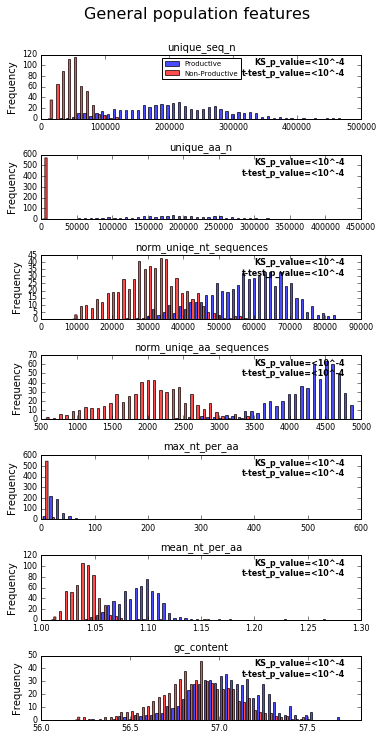

In [406]:
plot_res_df(general_res_df, general_function_list, 'General')

In [217]:
plt.close()

In [637]:
perProd_res_df.head()

,perc_prod_df_0
Sample,
HIP11513,77.957987
HIP08200,81.006286
HIP00769,85.163257
HIP09122,81.316962
HIP12091,81.169540


plotting results...
1
0


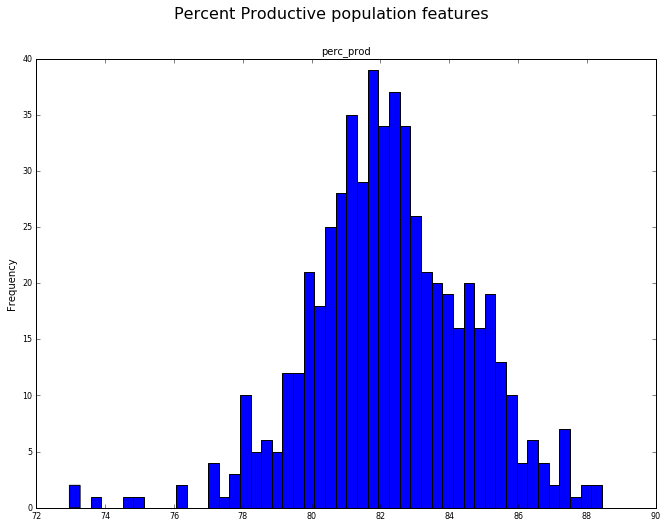

In [407]:

plot_1_res_df(perProd_res_df, percProd_func_list, 'Percent Productive')

plotting results...
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13


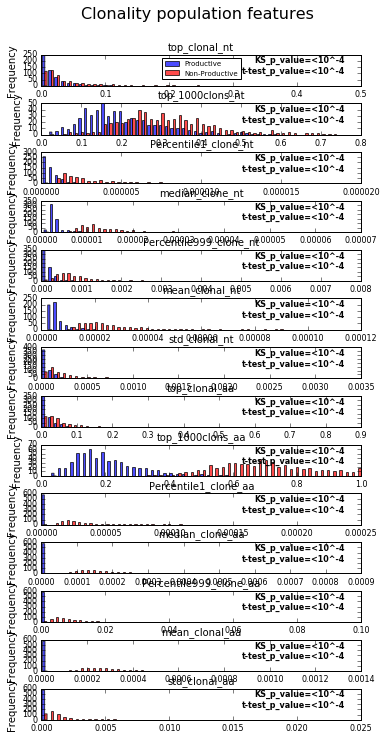

In [408]:
plot_res_df(clonality_res_df, clonality_func_list, 'Clonality')

plotting results...
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13


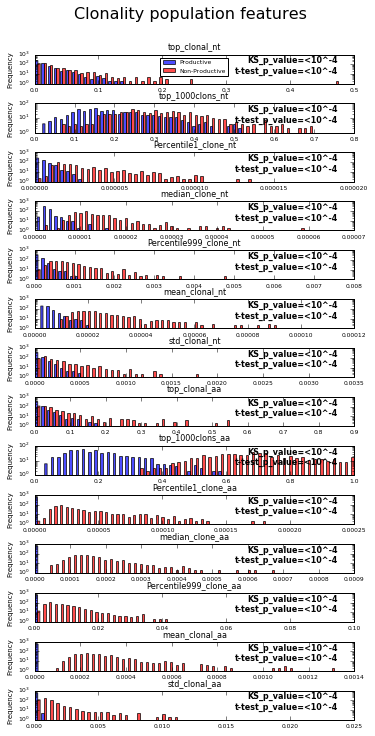

In [423]:
plot_res_df(clonality_res_df, clonality_func_list, 'Clonality', 'log', 0.68)

In [390]:
general_res_df.head()

,unique_seq_n_df_0,unique_seq_n_df_1,unique_aa_n_df_0,unique_aa_n_df_1,norm_uniqe_nt_sequences_df_0,norm_uniqe_nt_sequences_df_1,norm_uniqe_aa_sequences_df_0,norm_uniqe_aa_sequences_df_1,max_nt_per_aa_df_0,max_nt_per_aa_df_1,mean_nt_per_aa_df_0,mean_nt_per_aa_df_1,gc_content_df_0,gc_content_df_1
Sample,,,,,,,,,,,,,,
HIP11513,260601.0,70417.0,242606.0,6482.0,71149.3,44247.4,4715.8,2733.4,36.0,3.0,1.074,1.018,56.622047,56.501997
HIP08200,145768.0,33175.0,133947.0,2581.0,52455.3,23593.4,4209.6,1545.0,21.0,8.0,1.088,1.050,57.150388,56.713874
HIP00769,203018.0,35153.0,186405.0,2897.0,66963.5,26763.3,4747.3,1924.6,22.0,3.0,1.089,1.033,56.846168,56.758616
HIP09122,215813.0,53170.0,196567.0,4490.0,63969.5,35263.8,4663.5,2370.2,25.0,3.0,1.098,1.038,56.943040,56.894995
HIP12091,126607.0,29564.0,118382.0,2753.0,50227.3,24380.0,4138.4,1771.2,17.0,3.0,1.069,1.037,57.067690,56.920307


In [391]:
corr_df=general_res_df.corr()

In [392]:
print corr_df

                              unique_seq_n_df_0  unique_seq_n_df_1  \
unique_seq_n_df_0                      1.000000           0.946011   
unique_seq_n_df_1                      0.946011           1.000000   
unique_aa_n_df_0                       0.999121           0.942769   
unique_aa_n_df_1                       0.923786           0.984342   
norm_uniqe_nt_sequences_df_0           0.861014           0.800774   
norm_uniqe_nt_sequences_df_1           0.929009           0.948071   
norm_uniqe_aa_sequences_df_0           0.516654           0.481181   
norm_uniqe_aa_sequences_df_1           0.874230           0.889613   
max_nt_per_aa_df_0                    -0.047784          -0.050256   
max_nt_per_aa_df_1                    -0.026999           0.012060   
mean_nt_per_aa_df_0                    0.519744           0.537692   
mean_nt_per_aa_df_1                   -0.112241          -0.023992   
gc_content_df_0                        0.017279           0.179959   
gc_content_df_1     

plotting results...
6
0
1
2
3
4
5


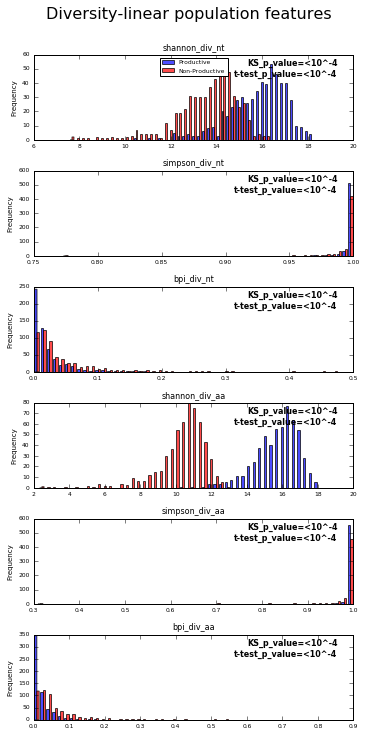

In [548]:
plot_res_df(diversity_res_df, diversity_func_list, 'Diversity-linear', 'linear', 0.36)

plotting results...
6
0
1
2
3
4
5


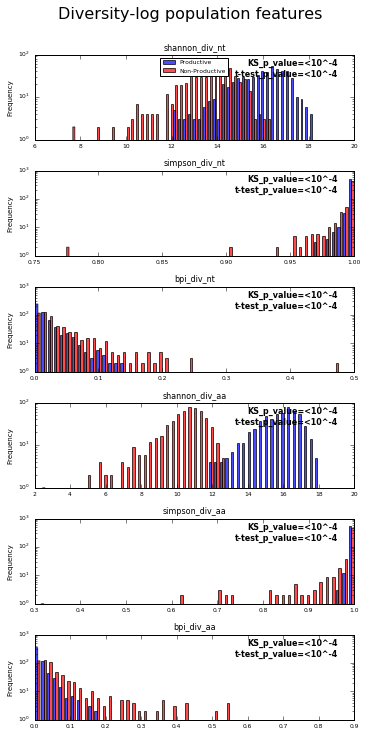

In [549]:
plot_res_df(diversity_res_df, diversity_func_list, 'Diversity-log', 'log', 0.36)

plotting results...
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13


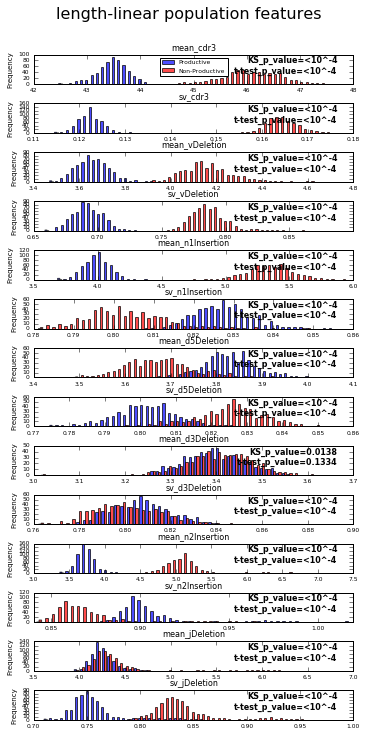

In [568]:
plot_res_df(length_res_df, length_func_list, 'length-linear', 'linear', 0.66)

plotting results...
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13


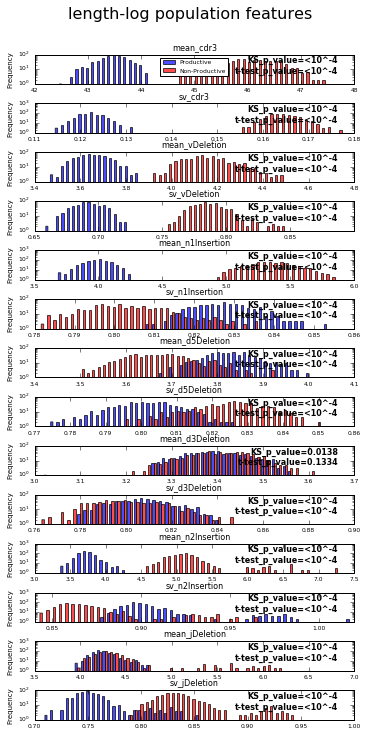

In [569]:
plot_res_df(length_res_df, length_func_list, 'length-log', 'log', 0.66)

In [559]:
import time
print "Current date "  + time.strftime("%x")

Current date 01/31/17


In [560]:
cdate=str(time.strftime("%x"))

In [561]:
print cdate

01/31/17


In [570]:
length_res_fig_linear=plot_res_df(length_res_df, length_func_list, 'length-linear', 'linear', 0.66)

plotting results...
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [571]:
length_res_fig_log=plot_res_df(length_res_df, length_func_list, 'length-log', 'log', 0.66)

plotting results...
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [572]:
diversity_res_fig_linear=plot_res_df(diversity_res_df, diversity_func_list, 'Diversity-linear', 'linear', 0.36)

plotting results...
6
0
1
2
3
4
5


In [594]:
diversity_res_fig_log=plot_res_df(diversity_res_df, diversity_func_list, 'Diversity-log', 'log', 0.36)

plotting results...
6
0
1
2
3
4
5


## plotting public analysis results

public_res_df_combined is loaded from pickle, the public functions and function list is copied from the 'public' notebook. 

In [644]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/public_res_df_combined', 'rb') as f:
    public_res_df_combined=pickle.load(f)
f.close()

In [645]:
public_res_df_combined.head()

,perc_public_df_0,perc_public_df_1,public10perc_df_0,public10perc_df_1,public50perc_df_0,public50perc_df_1,public95perc_df_0,public95perc_df_1,meanSharedSamples_df_0,meanSharedSamples_df_1,cdr3PriToPub_df_0,cdr3PriToPub_df_1,cdr3PriToPub95_df_0,cdr3PriToPub95_df_1
Sample,,,,,,,,,,,,,,
HIP09365,54.980117,7.120045,12.120690,0.037573,1.746403,0.0,0.024597,0.0,26.243074,1.291941,1.093374,1.170739,1.265726,NaN
HIP05533,54.014608,5.991516,11.947385,0.026511,1.766843,0.0,0.025434,0.0,25.909560,1.274920,1.105388,1.180347,1.282926,NaN
HIP13893,52.052226,5.884371,10.844156,0.017156,1.509827,0.0,0.020835,0.0,23.578078,1.244124,1.105201,1.197626,1.286461,NaN
HIP13427,53.886438,7.218632,10.402663,0.036581,1.177351,0.0,0.014440,0.0,22.125660,1.280332,1.099480,1.175638,1.283347,NaN
HIP01798,52.861126,6.713781,11.729311,0.110424,1.889867,0.0,0.030085,0.0,25.947240,1.353578,1.107016,1.186070,1.286112,NaN


In [646]:
## public population functions:


def perc_public(df):
    n_public=len(df[df['n_samples']>1])
    perc_public=(float(n_public)/len(df['n_samples']))*100
    return perc_public

def public10perc(df):
    n_public10=len(df[df['n_samples']>57])
    perc_public10=(float(n_public10)/len(df['n_samples']))*100
    return perc_public10

def public50perc(df):
    n_public50=len(df[df['n_samples']>286])
    perc_public50=(float(n_public50)/len(df['n_samples']))*100
    return perc_public50

def public95perc(df):
    n_public95=len(df[df['n_samples']>544])
    perc_public95=(float(n_public95)/len(df['n_samples']))*100
    return perc_public95

def meanSharedSamples(df):
    mean_shared=df['n_samples'].mean()
    return mean_shared

def cdr3PriToPub(df):
    mean_cdr3_pri=df[df['n_samples']==1]['cdr3Length'].mean()
    mean_cdr3_pub=df[df['n_samples']>1]['cdr3Length'].mean()
    cdr3PriToPub=float(mean_cdr3_pri)/mean_cdr3_pub
    return cdr3PriToPub

def cdr3PriToPub95(df):
    mean_cdr3_pri=df[df['n_samples']==1]['cdr3Length'].mean()
    mean_cdr3_pub95=df[df['n_samples']>544]['cdr3Length'].mean()
    cdr3PriToPub95=float(mean_cdr3_pri)/mean_cdr3_pub95
    return cdr3PriToPub95

In [624]:
public_res_df_combined_toPlot=public_res_df_combined.drop(['public50perc_df_0','public50perc_df_1','public95perc_df_0','public95perc_df_1','cdr3PriToPub95_df_0','cdr3PriToPub95_df_1'], axis=1)
## remove features which have data only for productive sequences (those features are plotted seperately)

In [647]:
columns_to_keep=['public50perc_df_0','public95perc_df_0', 'cdr3PriToPub95_df_0']
public_res_df_combined_toPlot1=public_res_df_combined[columns_to_keep]
## generate df for features that have data only in productive sequences

In [648]:
public_res_df_combined_toPlot.head()

,perc_public_df_0,perc_public_df_1,public10perc_df_0,public10perc_df_1,meanSharedSamples_df_0,meanSharedSamples_df_1,cdr3PriToPub_df_0,cdr3PriToPub_df_1
Sample,,,,,,,,
HIP09365,54.980117,7.120045,12.120690,0.037573,26.243074,1.291941,1.093374,1.170739
HIP05533,54.014608,5.991516,11.947385,0.026511,25.909560,1.274920,1.105388,1.180347
HIP13893,52.052226,5.884371,10.844156,0.017156,23.578078,1.244124,1.105201,1.197626
HIP13427,53.886438,7.218632,10.402663,0.036581,22.125660,1.280332,1.099480,1.175638
HIP01798,52.861126,6.713781,11.729311,0.110424,25.947240,1.353578,1.107016,1.186070


In [652]:
public_func_list_toPlot=[perc_public, public10perc, meanSharedSamples, cdr3PriToPub]

In [653]:
public_func_list_toPlot1=[public50perc, public95perc, cdr3PriToPub95]

In [670]:
public_plot=plot_res_df(public_res_df_combined_toPlot, public_func_list_toPlot, 'Public-linear', 'linear', 0.20)

plotting results...
4
0
1
2
3


In [660]:
public_plot1=plot_1_res_df(public_res_df_combined_toPlot1, public_func_list_toPlot1, 'Public-linear', 'linear')

plotting results...
3
0
1


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


2


plotting results...
4
0
1
2
3


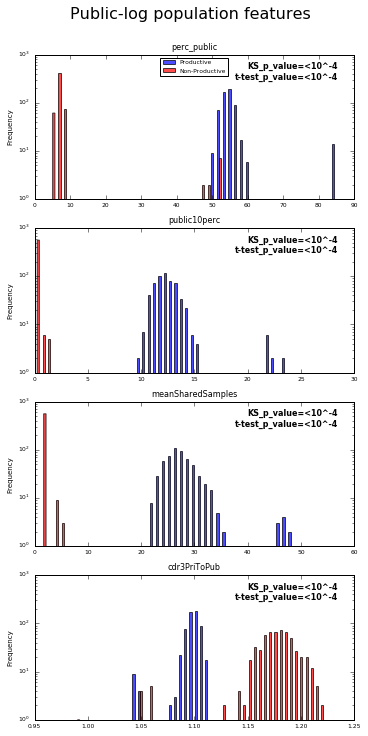

In [636]:
plot_res_df(public_res_df_combined_toPlot, public_func_list_toPlot, 'Public-log', 'log', 0.20)

## Generating A figures PDF:

In [659]:
cdate=str(time.strftime("%d%m%Y"))
create_pdf=True
figlist=[perc_prod_fig, general_res_fig_linear, general_res_fig_log, clonality_res_fig_linear, clonality_res_fig_log, diversity_res_fig_linear,
        diversity_res_fig_log,length_res_fig_linear, length_res_fig_log, public_plot, public_plot1]

if create_pdf:
    with PdfPages('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Images/population_View_%s_samples_%s.pdf' %(n_samples, cdate)) as pdf:
        for fig in figlist:
            pdf.savefig(fig)
    pdf.close
else:
    plt.show()

In [664]:
plt.savefig('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Images/Public-linear population features-1', dpi=300)

'''
    name, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)
'''

"\n    name, dpi=None, facecolor='w', edgecolor='w',\n        orientation='portrait', papertype=None, format=None,\n        transparent=False, bbox_inches=None, pad_inches=0.1,\n        frameon=None)\n"

In [672]:
plt.savefig('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Images/Public-linear population features', dpi=600)

## combining all results dataframes:

In [ ]:
public_result_with_tags_df=pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/public_result_with_tags_df', "rb"))
public_result_with_tags_df.head()

In [88]:
length_res_df_573_samples=pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/length_res_df_573_samples', "rb"))
clonality_res_df_573_samples=pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/clonality_res_df_573_samples', "rb"))
perProd_res_df_573_samples=pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/perProd_res_df_573_samples', "rb"))
general_res_df_573_samples=pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/general_res_df_573_samples', "rb"))
diversity_res_df_573_samples=pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/diversity_res_df_573_samples', "rb"))






In [ ]:
combined_res_with_tags_df=pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(general_res_df_573_samples,perProd_res_df_573_samples,how='outer', 
                                                     right_index=True,left_index=True), clonality_res_df_573_samples,how='outer',
                                                      right_index=True,left_index=True),length_res_df_573_samples, how='outer',
                                                      right_index=True,left_index=True),diversity_res_df_573_samples, how='outer',
                                                      right_index=True,left_index=True),public_result_with_tags_df,how='outer',
                                                      right_index=True,left_index=True)

In [90]:
combined_res_with_tags_describe=combined_res_with_tags_df.describe()

In [92]:
excel_writer='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/combined_res_with_tags_describe.xlsx'
combined_res_with_tags_describe.to_excel(excel_writer, sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True)

In [25]:
import time
cdate=str(time.strftime("%d%m%Y"))
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/combined_res_with_tags_df_%s' %cdate, 'wb') as f:
        pickle.dump(combined_res_with_tags_df,f)
f.close()

In [5]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/combined_res_with_tags_df_08032017', 'rb') as f:
        combined_res_with_tags_df=pickle.load(f)
f.close()

In [84]:
combined_res_with_tags_df.columns.values

array(['unique_seq_n_df_0', 'unique_seq_n_df_1', 'unique_aa_n_df_0',
       'unique_aa_n_df_1', 'norm_uniqe_nt_sequences_df_0',
       'norm_uniqe_nt_sequences_df_1', 'norm_uniqe_aa_sequences_df_0',
       'norm_uniqe_aa_sequences_df_1', 'max_nt_per_aa_df_0',
       'max_nt_per_aa_df_1', 'mean_nt_per_aa_df_0', 'mean_nt_per_aa_df_1',
       'gc_content_df_0', 'gc_content_df_1', 'perc_prod_df_0',
       'top_clonal_nt_df_0', 'top_clonal_nt_df_1', 'top_1000clons_nt_df_0',
       'top_1000clons_nt_df_1', 'Percentile1_clone_nt_df_0',
       'Percentile1_clone_nt_df_1', 'median_clone_nt_df_0',
       'median_clone_nt_df_1', 'Percentile999_clone_nt_df_0',
       'Percentile999_clone_nt_df_1', 'mean_clonal_nt_df_0',
       'mean_clonal_nt_df_1', 'std_clonal_nt_df_0', 'std_clonal_nt_df_1',
       'top_clonal_aa_df_0', 'top_clonal_aa_df_1', 'top_1000clons_aa_df_0',
       'top_1000clons_aa_df_1', 'Percentile1_clone_aa_df_0',
       'Percentile1_clone_aa_df_1', 'median_clone_aa_df_0',
       'med

## calculating correlations over the result df:
#### the significance is tested by both p-value and by permutation analysis:

##### define parameters: 

In [295]:
df=combined_res_with_tags_df #define the results df
corr_col='perc_public_df_0' #define the feature to calculate correlations with
n_per=10 #define the number of permutations

##### calculate real correlations and p-values

In [321]:
def calc_sig_corr(df, corr_col, n_per):
    from scipy.stats import pearsonr

    ## stage 1: calculate real correlations and generate dataframe
    print 'calculating real correlations'
    corr_list=[]
    n_tests=len(df.columns.values)
    for column in list(df.columns.values):
        if df[column].dtype == np.float64 or df[column].dtype == np.int64 :
            n1=np.isnan(df[column])
            n2=np.isnan(df[corr_col])
            n=n1|n2
            newx=list(df[column][~n])
            newy=list(df[corr_col][~n])
            r,p = pearsonr(newx,newy)
        else:
            r=np.nan
            p=np.nan
        corr_list.append({'column':column,'real_r':r, 'real_p':p})
    res_corr_df=pd.DataFrame(corr_list)
    res_corr_df.sort(columns='real_p', inplace=1)


    ## stage 2: permutate result df and calculate correlations over permutated data:
    for i in range(n_per):
        print i
        print 'start shuffling df'
        shuffle=df.apply(np.random.permutation)
        shuf_corr_list=[]
        #column_list=[]
        for column in list(shuffle.columns.values):
            #print ('start calculating r for column %s' %column)
            #column_list.append(column)
            if shuffle[column].dtype == np.float64 or shuffle[column].dtype == np.int64 :
                n1=np.isnan(shuffle[column])
                n2=np.isnan(shuffle[corr_col])
                n=n1|n2
                newx=list(shuffle[column][~n])
                newy=list(shuffle[corr_col][~n])
                r,p = pearsonr(newx,newy)
                shuf_corr_list.append(r)
            else:
                shuf_corr_list.append(np.nan)
        #shuffle_r_df.loc[:,('column_shuf_%s'%i)] = column_list
        res_corr_df.loc[:,('r_shuf_%s'%i)] = shuf_corr_list
    
    ## stage 3: calculate confidence interval for shuffled r's:
    #print shuffle_r_df.columns.values
    col_for_percentile=[col for col in res_corr_df.columns.values if col.startswith('r_shuf_')]
    #shuffle_r_df.loc[:,'r_mean']=np.mean(shuffle_r_df[col_for_percentile])
    #res_corr_df['avg'] = res_corr_df[col_for_percentile].mean(axis=1)
    res_corr_df['r_perc_2_5'] = res_corr_df[col_for_percentile].quantile(q=0.025,axis=1)
    res_corr_df['r_perc_97_5'] = res_corr_df[col_for_percentile].quantile(q=0.975,axis=1)
    
    ## stage 4: check significance of the correlations:
    res_correct_p=0.05/n_tests
    res_corr_df['real_p_sig']=np.where(res_corr_df['real_p']<0.05,1,0)
    res_corr_df['real_p_sig_corrected']=np.where(res_corr_df['real_p']<res_correct_p,1,0)
    res_corr_df['r_outof_CI']=np.where((res_corr_df['real_r']<res_corr_df['r_perc_2_5']) | (res_corr_df['real_r']>res_corr_df['r_perc_97_5']) ,1,0)
    col_to_keep=['column','real_p','real_r','r_perc_2_5','r_perc_97_5','real_p_sig','real_p_sig_corrected','r_outof_CI']
    res_corr_df=res_corr_df[col_to_keep]
    res_corr_df.set_index('column',inplace=1)
    only_sig_corr_df=res_corr_df[(res_corr_df['real_p_sig']==1) & (res_corr_df['r_outof_CI']==1)]
    
    return res_corr_df,only_sig_corr_df


In [42]:
 df10 = pd.DataFrame(np.random.randint(0,100,(100, 100)))

In [43]:
df10['r_perc_2_5'] = df10.quantile(q=0.025,axis=1)
df10['r_perc_97_5'] = df10.quantile(q=0.975,axis=1)
df10['r_perc_3'] = df10.quantile(q=0.03,axis=1)
df10['r_perc_97'] = df10.quantile(q=0.97,axis=1)


In [44]:
df10[['r_perc_2_5','r_perc_97_5','r_perc_3','r_perc_97']].mean()

r_perc_2_5      3.122250
r_perc_97_5    96.235000
r_perc_3        3.136582
r_perc_97      96.203500
dtype: float64

In [ ]:
percPublicProd_corr_df,percPublicProd_SigCorr_df=calc_sig_corr(combined_res_with_tags_df, 'perc_public_df_0', 1000)

In [328]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/percPublicProd_corr_df', 'wb') as f:
        pickle.dump(percPublicProd_corr_df,f)
f.close()

In [9]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/percPublicProd_corr_df', 'rb') as f:
        percPublicProd_corr_df=pickle.load(f)
f.close()

In [13]:
percPublicProd_corr_df[50:]

,real_p,real_r,r_perc_2_5,r_perc_97_5,real_p_sig,real_p_sig_corrected,r_outof_CI
column,,,,,,,
mean_jDeletion_df_0,0.051086,-0.081536,-0.078275,0.085349,0,0,1
sv_d5Deletion_df_0,0.061491,0.078169,-0.083325,0.082055,0,0,0
Percentile999_clone_nt_df_1,0.075615,0.074283,-0.084934,0.081464,0,0,0
median_clone_aa_df_1,0.079597,0.073295,-0.080635,0.082387,0,0,0
Percentile1_clone_aa_df_1,0.104741,0.067842,-0.081395,0.089324,0,0,0
sv_d3Deletion_df_1,0.113779,0.066137,-0.085739,0.080002,0,0,0
std_clonal_nt_df_1,0.114157,0.066068,-0.081523,0.080262,0,0,0
mean_d3Deletion_df_0,0.115276,-0.065865,-0.086868,0.078091,0,0,0
Percentile999_clone_aa_df_1,0.123666,0.064390,-0.083549,0.077152,0,0,0


In [330]:
print len(percPublicProd_SigCorr_df)
print len(percPublicProd_corr_df)

49
100


In [ ]:
meanSharedProd_corr_df,meanSharedProd_SigCorr_df=calc_sig_corr(combined_res_with_tags_df, 'meanSharedSamples_df_0', 1000)

In [332]:
meanSharedProd_SigCorr_df.head()

,real_p,real_r,r_perc_2_5,r_perc_97_5,real_p_sig,real_p_sig_corrected,r_outof_CI
column,,,,,,,
public10perc_df_0,0.000000e+00,0.986843,-0.079446,0.085286,1,1,1
meanSharedSamples_df_0,0.000000e+00,1.000000,-0.079210,0.088426,1,1,1
public50perc_df_0,1.027939e-240,0.924101,-0.085206,0.081900,1,1,1
perc_public_df_0,1.399179e-168,0.859521,-0.071554,0.087890,1,1,1
perc_public_df_1,2.761440e-111,0.765182,-0.082121,0.082363,1,1,1


In [333]:
print len(meanSharedProd_SigCorr_df)
print len(meanSharedProd_corr_df)

74
100


In [334]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/meanSharedProd_corr_df', 'wb') as f:
        pickle.dump(meanSharedProd_corr_df,f)
f.close()

In [14]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/meanSharedProd_corr_df', 'rb') as f:
        meanSharedProd_corr_df=pickle.load(f)
f.close()

In [45]:
meanSharedProd_corr_df[:50]

,real_p,real_r,r_perc_2_5,r_perc_97_5,real_p_sig,real_p_sig_corrected,r_outof_CI
column,,,,,,,
public10perc_df_0,0.000000e+00,0.986843,-0.079446,0.085286,1,1,1
meanSharedSamples_df_0,0.000000e+00,1.000000,-0.079210,0.088426,1,1,1
public50perc_df_0,1.027939e-240,0.924101,-0.085206,0.081900,1,1,1
perc_public_df_0,1.399179e-168,0.859521,-0.071554,0.087890,1,1,1
perc_public_df_1,2.761440e-111,0.765182,-0.082121,0.082363,1,1,1
meanSharedSamples_df_1,3.377878e-107,0.756062,-0.087196,0.078673,1,1,1
public95perc_df_0,1.237429e-97,0.733028,-0.087776,0.072508,1,1,1
cdr3PriToPub_df_0,1.264224e-91,-0.717211,-0.076358,0.085188,1,1,1
cdr3PriToPub95_df_0,1.221614e-84,-0.697352,-0.061253,0.107459,1,1,1


In [48]:
writer='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/meanSharedProd_corr_df.xlsx'
meanSharedProd_corr_df.to_excel(writer, sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True)

In [49]:
writer='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/percPublicProd_corr_df.xlsx'
percPublicProd_corr_df.to_excel(writer, sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True)

In [8]:
combined_res_with_tags_df_corr.sort(columns='meanSharedSamples_df_0',ascending=False)['meanSharedSamples_df_0'][:50]
                                                                

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


meanSharedSamples_df_0         1.000000
public10perc_df_0              0.986843
public50perc_df_0              0.924101
perc_public_df_0               0.859521
perc_public_df_1               0.765182
meanSharedSamples_df_1         0.756062
public95perc_df_0              0.733028
public10perc_df_1              0.629168
top_1000clons_aa_df_1          0.538431
mean_clonal_aa_df_0            0.534259
mean_clonal_nt_df_0            0.534099
mean_clonal_nt_df_1            0.533146
mean_clonal_aa_df_1            0.523171
median_clone_aa_df_0           0.458309
median_clone_nt_df_0           0.452359
median_clone_aa_df_1           0.446606
median_clone_nt_df_1           0.442006
Percentile999_clone_nt_df_1    0.440972
Percentile999_clone_nt_df_0    0.438084
Percentile999_clone_aa_df_0    0.436312
top_1000clons_nt_df_1          0.370561
Percentile999_clone_aa_df_1    0.366985
Percentile1_clone_aa_df_0      0.314805
Percentile1_clone_nt_df_0      0.314805
Percentile1_clone_aa_df_1      0.311597


In [9]:
combined_res_with_tags_df_corr.sort(columns='perc_public_df_0',ascending=False)['perc_public_df_0'][0:50]

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


perc_public_df_0               1.000000
perc_public_df_1               0.947158
public10perc_df_0              0.926230
meanSharedSamples_df_1         0.919876
meanSharedSamples_df_0         0.859521
public10perc_df_1              0.770495
public50perc_df_0              0.603654
public95perc_df_0              0.327995
Age                            0.133358
top_1000clons_aa_df_1          0.129402
sv_n1Insertion_df_1            0.126380
top_clonal_aa_df_0             0.114510
bpi_div_aa_df_0                0.114510
top_clonal_nt_df_0             0.114310
bpi_div_nt_df_0                0.114310
std_clonal_nt_df_0             0.109799
std_clonal_aa_df_0             0.109712
mean_clonal_aa_df_1            0.103292
mean_clonal_nt_df_1            0.102371
mean_clonal_nt_df_0            0.092911
mean_clonal_aa_df_0            0.092875
top_1000clons_nt_df_1          0.090368
top_1000clons_aa_df_0          0.085851
top_1000clons_nt_df_0          0.085628
sv_n1Insertion_df_0            0.085266


In [11]:
combined_res_with_tags_df_corr.sort(columns='perc_public_df_0',ascending=False)['perc_public_df_0'][50:]

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


max_nt_per_aa_df_0              0.024767
sv_n2Insertion_df_1             0.009850
gc_content_df_0                 0.005089
sv_d5Deletion_df_1              0.003235
sv_vDeletion_df_0               0.000141
mean_vDeletion_df_0            -0.006542
sv_vDeletion_df_1              -0.006847
mean_nt_per_aa_df_1            -0.008811
mean_nt_per_aa_df_0            -0.012299
mean_vDeletion_df_1            -0.013560
sv_jDeletion_df_1              -0.022639
sv_n2Insertion_df_0            -0.026956
simpson_div_nt_df_1            -0.029972
mean_d5Deletion_df_0           -0.035620
mean_jDeletion_df_1            -0.038759
mean_d3Deletion_df_1           -0.040918
simpson_div_aa_df_1            -0.053750
mean_d3Deletion_df_0           -0.065865
mean_jDeletion_df_0            -0.081536
sv_jDeletion_df_0              -0.082490
norm_uniqe_aa_sequences_df_0   -0.090506
shannon_div_nt_df_1            -0.093858
shannon_div_aa_df_1            -0.097495
unique_seq_n_df_0              -0.105723
simpson_div_aa_d

In [1]:
def draw_correlation_scatter(x, y, figsize = (3, 3), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = None, ms=4, logd = False,\
                             xlab = None, ylab = None, filename = None, title = None,
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False, **figkwargs):
    from scipy.stats import pearsonr
    fig = plt.figure(figsize = figsize, dpi = dpi)
    axB = fig.add_subplot(111)
    if contour:
        print "Contour plot are experimental here"
        axB.hist2d(x,y,bins = 40,norm=LogNorm())
    else:
        axB.plot(x, y, 'o', color = color, ms=ms, **figkwargs)
    if logd:
        axB.set_xscale('log',basex=2)
        axB.set_yscale('log',basey=2)
    if xticks is not None:
        axB.set_xticks(xticks)
        axB.set_xticklabels(xticks)
    if xticklabels is not None:
        axB.set_xticklabels(xticklabels)
    if yticks is not None:
        axB.set_yticks(yticks)
        axB.set_yticklabels(yticks)
    if xlim is not None:
        axB.set_xlim(xlim)
    if ylim is not None:
        axB.set_ylim(ylim)
    if r is not None: 
        if r == True:
            n=np.isnan(x)
            newx=list(x[~n])
            newy=list(y[~n])
            r,p = pearsonr(newx,newy)
        axB.text(0.01,0.99,"r=%.4f p=%.4f" %(r,p), transform=axB.transAxes, verticalalignment = 'top', ha = 'left',fontsize=14,color='red')
    if xlab is not None:
        axB.set_xlabel(xlab)
    if ylab is not None:
        axB.set_ylabel(ylab)
    if title is not None:
        plt.title(title, fontsize=16)
    if grid:
        axB.grid()
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight', dpi = dpi)
    return fig, axB


In [74]:
def draw_multiple_correlation_scatter(x, y, ynames=None, figsize = (4, 4), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = None, ms=4, logd = False,\
                             xlab = None, ylab = None, filename = None, title = None,
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False, **figkwargs):
    from scipy.stats import pearsonr
    fig = plt.figure(figsize = figsize, dpi = dpi)
    axB = fig.add_subplot(111)
    if contour:
        print "Contour plot are experimental here"
        axB.hist2d(x,y,bins = 40,norm=LogNorm())
    else:
        for i in range(len(y)):
            axB.plot(x, y[i], 'o', color = color[i], ms=ms[i], label=ynames[i], **figkwargs)
    axB.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #axB.legend(loc='best',fontsize=10)
    if logd:
        axB.set_xscale('log',basex=2)
        axB.set_yscale('log',basey=2)
    if xticks is not None:
        axB.set_xticks(xticks)
        axB.set_xticklabels(xticks)
    if xticklabels is not None:
        axB.set_xticklabels(xticklabels)
    if yticks is not None:
        axB.set_yticks(yticks)
        axB.set_yticklabels(yticks)
    if xlim is not None:
        axB.set_xlim(xlim)
    if ylim is not None:
        axB.set_ylim(ylim)
    if r is not None: 
        if r == True:
            n=np.isnan(x)
            newx=list(x[~n])
            newy_l=[]
            r_l=[]
            p_l=[]
            posR=0.99
            for i in range(len(y)):
                newy=list(y[i][~n])
                r,p = pearsonr(newx,newy)
                newy_l.append(newy)
                r_l.append(r)
                p_l.append(p)
                axB.text(0.01,posR,"r=%.4f p=%.4f" %(r,p), transform=axB.transAxes, verticalalignment = 'top', ha = 'left',fontsize=10,color=color[i])
                posR=posR-0.03
    if xlab is not None:
        axB.set_xlabel(xlab)
    if ylab is not None:
        axB.set_ylabel(ylab)
    if title is not None:
        plt.title(title, fontsize=16)
    if grid:
        axB.grid()
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight', dpi = dpi)
    return fig, axB


In [15]:
combined_res_with_tags_noOutliers=combined_res_with_tags_df[combined_res_with_tags_df['perc_public_df_0']<80]

In [3]:
Age_nShared_correl_fig=draw_correlation_scatter(combined_res_with_tags_df['Age'], combined_res_with_tags_df['perc_public_df_0'], figsize = (6, 6), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=6, logd = False,\
                             xlab = 'Age', ylab = 'Percent Public-Productive sequences', filename = 'Age-Percent Public correlation', title = 'Age-Percent Public correlation',
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

NameError: name 'combined_res_with_tags_df' is not defined

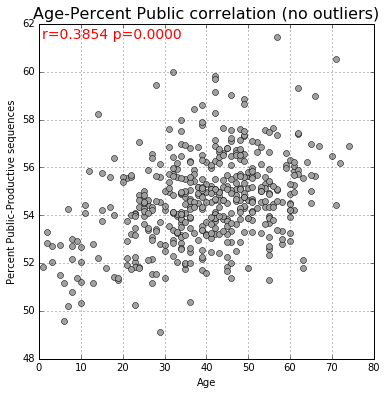

In [103]:
Age_nShared_correl_no_outliers_fig=draw_correlation_scatter(combined_res_with_tags_noOutliers['Age'], combined_res_with_tags_noOutliers['perc_public_df_0'], figsize = (6, 6), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=6, logd = False,\
                             xlab = 'Age', ylab = 'Percent Public-Productive sequences', filename = 'Age-Percent Public correlation-noOutliers', title = 'Age-Percent Public correlation (no outliers)',
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

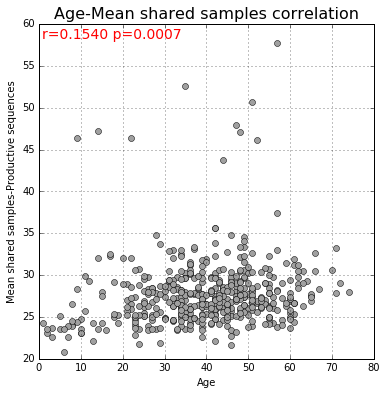

In [104]:
Age_meanShared_correl_fig=draw_correlation_scatter(combined_res_with_tags_df['Age'], combined_res_with_tags_df['meanSharedSamples_df_0'], figsize = (6, 6), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=6, logd = False,\
                             xlab = 'Age', ylab = 'Mean shared samples-Productive sequences', filename = 'Age-Mean shared samples correlation', title = 'Age-Mean shared samples correlation',
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

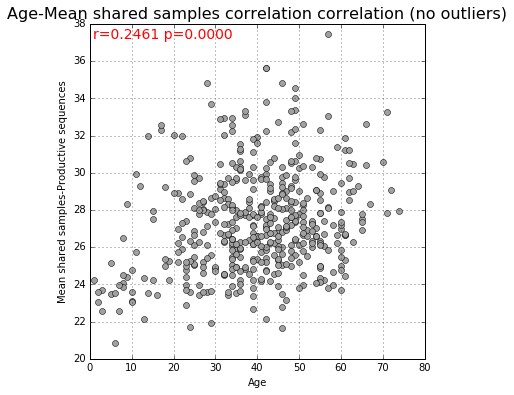

In [105]:
Age_meanShared_correl_no_outliers_fig=draw_correlation_scatter(combined_res_with_tags_noOutliers['Age'], combined_res_with_tags_noOutliers['meanSharedSamples_df_0'], figsize = (6, 6), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=6, logd = False,\
                             xlab = 'Age', ylab = 'Mean shared samples-Productive sequences', filename = 'Age-Mean shared samples correlation-noOutliers', title = 'Age-Mean shared samples correlation correlation (no outliers)',
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

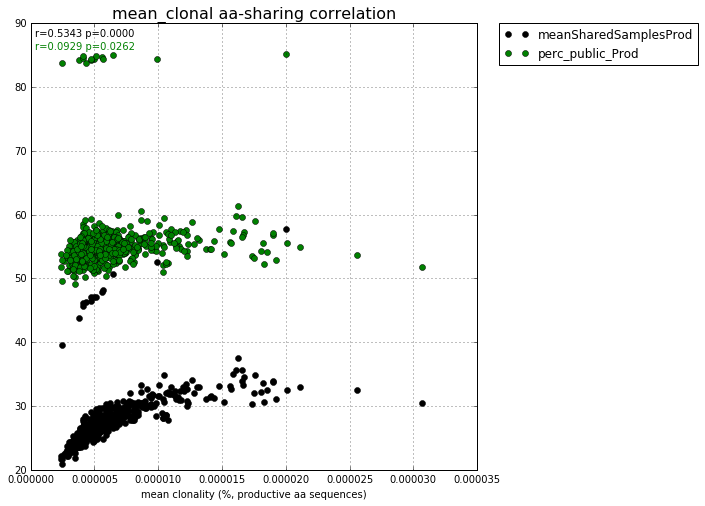

In [92]:
meanclonalaa_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['mean_clonal_aa_df_0'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'mean clonality (%, productive aa sequences)', ylab = '', filename = 'mean_clonal aa-sharing correlation', title = 'mean_clonal aa-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

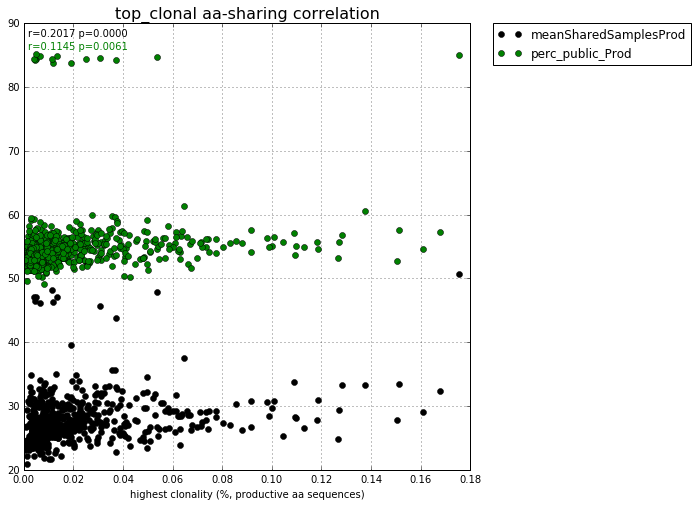

In [93]:
topclonalaa_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['top_clonal_aa_df_0'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'highest clonality (%, productive aa sequences)', ylab = '', filename = 'top_clonal aa-sharing correlation', title = 'top_clonal aa-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

In [ ]:
top_clonal_aa_df_0

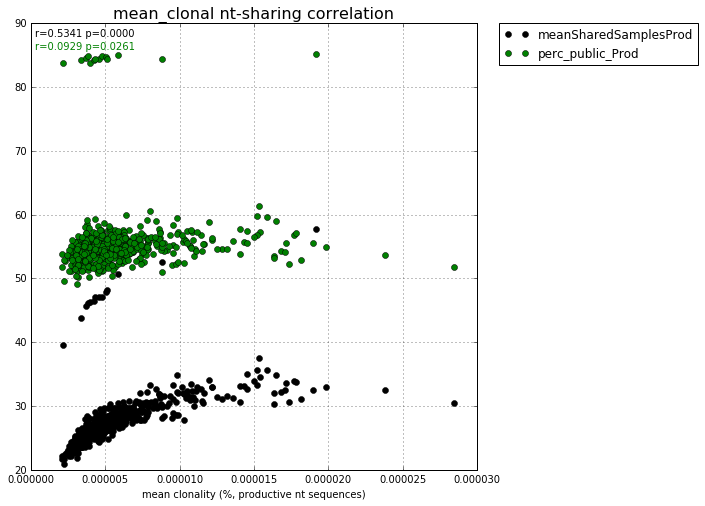

In [94]:
meanclonalnt_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['mean_clonal_nt_df_0'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'mean clonality (%, productive nt sequences)', ylab = '', filename = 'mean_clonal_nt-sharing correlation', title = 'mean_clonal nt-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

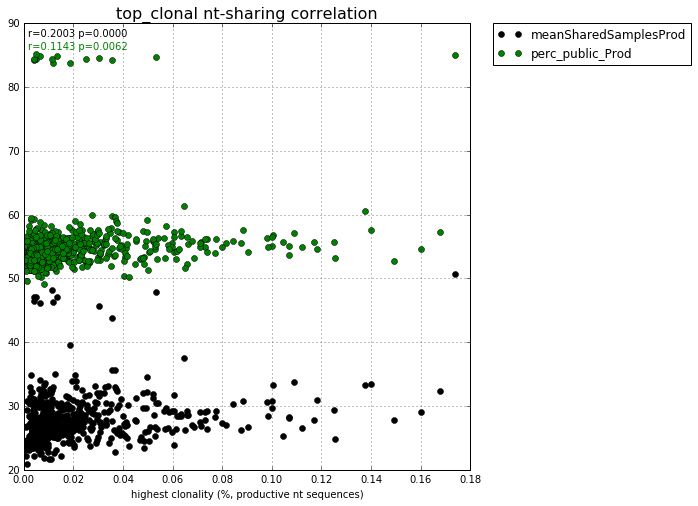

In [95]:
topclonalnt_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['top_clonal_nt_df_0'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'highest clonality (%, productive nt sequences)', ylab = '', filename = 'top_clonal_nt-sharing correlation', title = 'top_clonal nt-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

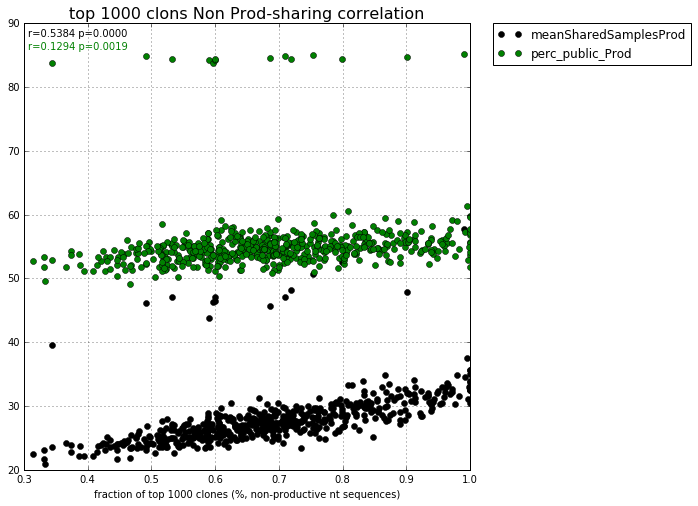

In [75]:
top1000clonsNonProd_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['top_1000clons_aa_df_1'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'fraction of top 1000 clones (%, non-productive nt sequences)', ylab = '', filename = 'top1000clonsNonProd-sharing correlation', title = 'top 1000 clons Non Prod-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()


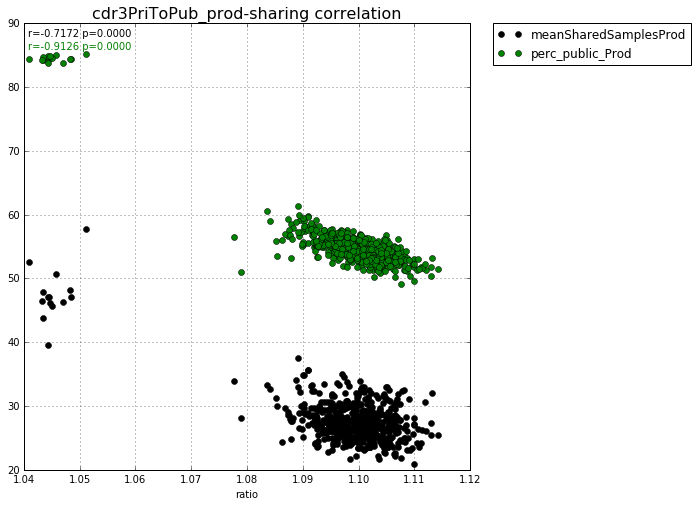

In [96]:
cdr3priToPub_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['cdr3PriToPub_df_0'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'ratio', ylab = '', filename = 'cdr3PriToPub_prod-sharing correlation', title = 'cdr3PriToPub_prod-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

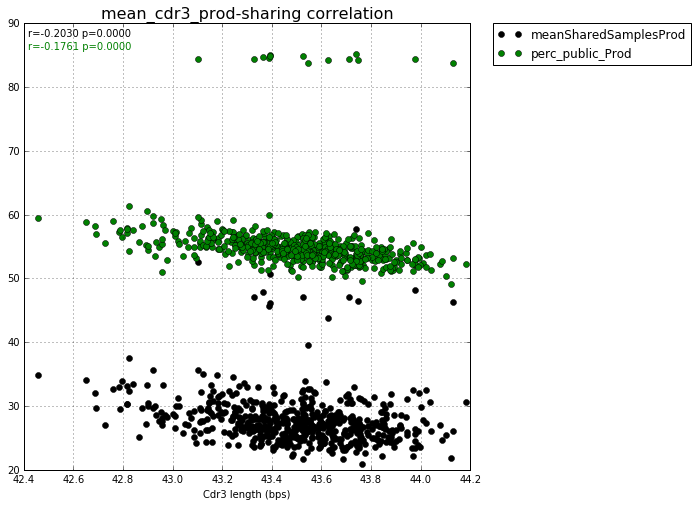

In [97]:
meanCDR3_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['mean_cdr3_df_0'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'Cdr3 length (bps)', ylab = '', filename = 'mean_cdr3_prod-sharing correlation', title = 'mean_cdr3_prod-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()

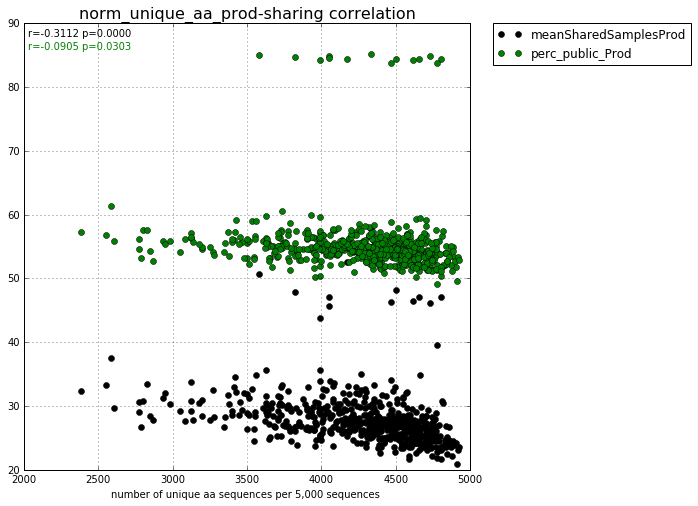

In [117]:
normUniqueAA_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['norm_uniqe_aa_sequences_df_0'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'number of unique aa sequences per 5,000 sequences ', ylab = '', filename = 'norm_unique_aa_prod-sharing correlation', title = 'norm_unique_aa_prod-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()


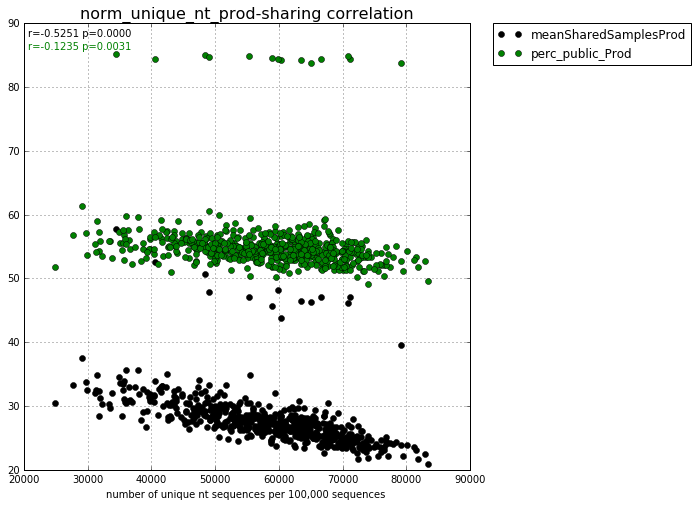

In [116]:
normUniqueNT_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['norm_uniqe_nt_sequences_df_0'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'number of unique nt sequences per 100,000 sequences ', ylab = '', filename = 'norm_unique_nt_prod-sharing correlation', title = 'norm_unique_nt_prod-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()


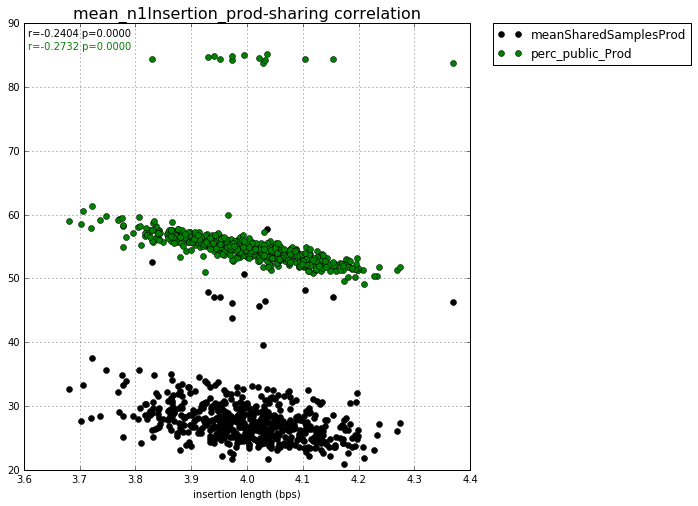

In [126]:
meanN1Insertion_2sharing_correl_fig=draw_multiple_correlation_scatter(combined_res_with_tags_df['mean_n1Insertion_df_0'], [combined_res_with_tags_df['meanSharedSamples_df_0'], combined_res_with_tags_df['perc_public_df_0']], ynames=['meanSharedSamplesProd','perc_public_Prod'], figsize = (8, 8), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=[6,6], logd = False,\
                             xlab = 'insertion length (bps)', ylab = '', filename = 'mean_n1Insertion_prod-sharing correlation', title = 'mean_n1Insertion_prod-sharing correlation',
                             color = ['black','green'], grid = True, dpi = 800, xticklabels = None, 
                             contour = False)
plt.show()


#### calculating gender differences for all features:

In [50]:
from scipy.stats import ttest_ind

males = combined_res_with_tags_df[combined_res_with_tags_df['Gender']=='Male']
females = combined_res_with_tags_df[combined_res_with_tags_df['Gender']=='Female']


ttest_list=[]
for column in list(combined_res_with_tags_df.columns.values):
    if column == 'Gender' or column == '_merge' :
        print column
    else:
        t,p=ttest_ind(males[column], females[column])
        ttest_list.append({'column':column,'p-value':p})
genderDiff_df=pd.DataFrame(ttest_list)
genderDiff_df.sort(columns='p-value', inplace=1)






Gender
_merge


/usr/wisdom/python/lib/python2.7/site-packages/scipy/stats/stats.py:3658: RuntimeWarning: invalid value encountered in absolute
  prob = distributions.t.sf(np.abs(t), df) * 2  # use np.abs to get upper tail
/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [51]:
genderDiff_df.head()

,column,p-value
12,gc_content_df_0,0.000012
13,gc_content_df_1,0.001576
3,unique_aa_n_df_1,0.002300
72,shannon_div_nt_df_1,0.002835
18,top_1000clons_nt_df_1,0.003112


In [52]:
genderDiff_df['sig']=np.where(genderDiff_df['p-value']<0.0005, 1, 0)

In [53]:
from statsmodels.sandbox.stats.multicomp import multipletests
pvals=list(genderDiff_df['p-value'])
reject,BHpval_df,x,y=multipletests(pvals, alpha=0.01, method='hs', returnsorted=False)
reject,bonferroni_df,x,y=multipletests(pvals, alpha=0.01, method='bonferroni', returnsorted=False)
genderDiff_df['BH FDR']=BHpval_df
genderDiff_df['bonferroni FDR']=bonferroni_df

/usr/wisdom/python/lib/python2.7/site-packages/statsmodels/stats/multitest.py:157: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
/usr/wisdom/python/lib/python2.7/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1
/usr/wisdom/python/lib/python2.7/site-packages/statsmodels/stats/multitest.py:147: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals <= alphacBonf


In [56]:
genderDiff_df[50:]

,column,p-value,sig,BH FDR,bonferroni FDR
89,public95perc_df_0,0.190763,0,0.999961,1.0
78,shannon_div_aa_df_1,0.196122,0,0.999965,1.0
29,top_clonal_aa_df_0,0.204691,0,0.999973,1.0
81,bpi_div_aa_df_0,0.204692,0,0.999973,1.0
35,median_clone_aa_df_0,0.212939,0,0.999973,1.0
15,top_clonal_nt_df_0,0.216484,0,0.999973,1.0
75,bpi_div_nt_df_0,0.216486,0,0.999973,1.0
44,mean_cdr3_df_1,0.220989,0,0.999973,1.0
66,sv_n2Insertion_df_1,0.259858,0,0.999994,1.0
9,max_nt_per_aa_df_1,0.290420,0,0.999998,1.0


In [63]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/genderDiff_df', 'wb') as f:
        pickle.dump(genderDiff_df, f)
f.close()

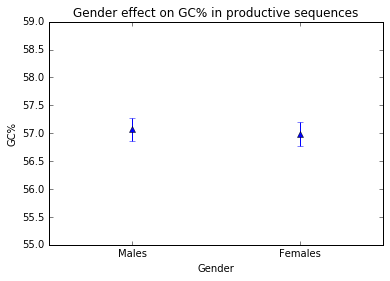

In [85]:
gcMaleMean=np.mean(males['gc_content_df_0'])
gcFemaleMean=np.mean(females['gc_content_df_0'])
gcMaleSTD=np.std(males['gc_content_df_0'])
gcFemaleSTD=np.std(females['gc_content_df_0'])
means=[gcMaleMean,gcFemaleMean]
stds=[gcMaleSTD,gcFemaleSTD ]


plt.errorbar([1,2], means, stds, linestyle='None', marker='^')
plt.xticks([1,2],['Males','Females'])
plt.xlim(0.5,2.5)
plt.title('Gender effect on GC% in productive sequences')
plt.xlabel('Gender')
plt.ylabel('GC%')

plt.ylim(55,59)
plt.show()

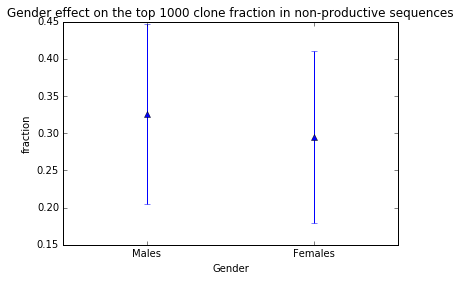

In [78]:
top1000MaleMean=np.mean(males['top_1000clons_nt_df_1'])
top1000FemaleMean=np.mean(females['top_1000clons_nt_df_1'])
top1000MaleSTD=np.std(males['top_1000clons_nt_df_1'])
top1000FemaleSTD=np.std(females['top_1000clons_nt_df_1'])
means=[top1000MaleMean,top1000FemaleMean]
stds=[top1000MaleSTD,top1000FemaleSTD ]


plt.errorbar([1,2], means, stds, linestyle='None', marker='^')
plt.xticks([1,2],['Males','Females'])
plt.xlim(0.5,2.5)
plt.title('Gender effect on the top 1000 clone fraction in non-productive sequences')
plt.xlabel('Gender')
plt.ylabel('fraction')
plt.show()

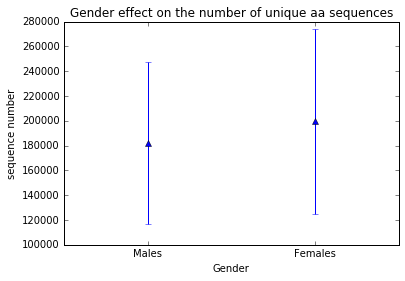

In [80]:
uniqueAAMaleMean=np.mean(males['unique_aa_n_df_0'])
uniqueAAFemaleMean=np.mean(females['unique_aa_n_df_0'])
uniqueAAMaleSTD=np.std(males['unique_aa_n_df_0'])
uniqueAAFemaleSTD=np.std(females['unique_aa_n_df_0'])
means=[uniqueAAMaleMean,uniqueAAFemaleMean]
stds=[uniqueAAMaleSTD,uniqueAAFemaleSTD ]


plt.errorbar([1,2], means, stds, linestyle='None', marker='^')
plt.xticks([1,2],['Males','Females'])
plt.xlim(0.5,2.5)
plt.title('Gender effect on the number of unique aa sequences')
plt.xlabel('Gender')
plt.ylabel('sequence number')
plt.show()

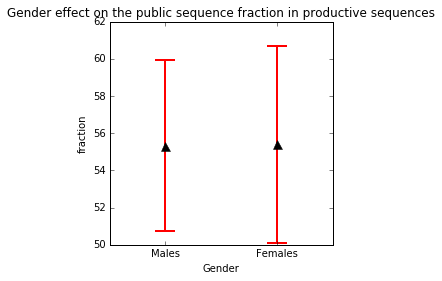

In [72]:
percPublicMaleMean=np.mean(males['perc_public_df_0'])
percPublicFemaleMean=np.mean(females['perc_public_df_0'])
percPublicMaleSTD=np.std(males['perc_public_df_0'])
percPublicFemaleSTD=np.std(females['perc_public_df_0'])
means=[percPublicMaleMean,percPublicFemaleMean]
stds=[percPublicMaleSTD,percPublicFemaleSTD ]

GenderOnPercPublicProdFig = plt.figure(figsize = (4,4))
plt.errorbar([1,2], means, stds, linestyle='None', marker='^',capsize=10, capthick=2, markerfacecolor='black',elinewidth=2, markersize=9, color='red')
plt.xticks([1,2],['Males','Females'])
plt.xlim(0.5,2.5)
plt.title('Gender effect on the public sequence fraction in productive sequences')
plt.xlabel('Gender')
plt.ylabel('fraction')
GenderOnPercPublicProdFig.savefig('GenderOnPercPublicProdFig', bbox_inches='tight', dpi = 800)
plt.show()

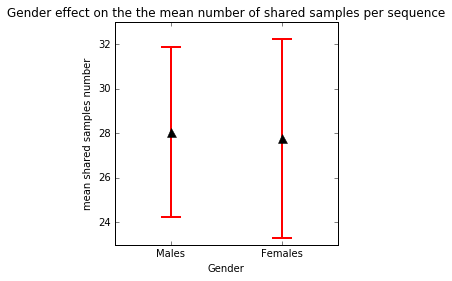

In [70]:
percPublicMaleMean=np.mean(males['meanSharedSamples_df_0'])
percPublicFemaleMean=np.mean(females['meanSharedSamples_df_0'])
percPublicMaleSTD=np.std(males['meanSharedSamples_df_0'])
percPublicFemaleSTD=np.std(females['meanSharedSamples_df_0'])
means=[percPublicMaleMean,percPublicFemaleMean]
stds=[percPublicMaleSTD,percPublicFemaleSTD ]


GenderOnMeanSharedSamplesProdFig = plt.figure(figsize = (4,4))
plt.errorbar([1,2], means, stds, linestyle='None', marker='^',capsize=10, capthick=2, markerfacecolor='black',elinewidth=2, markersize=9, color='red')
plt.xticks([1,2],['Males','Females'])
plt.xlim(0.5,2.5)
plt.title('Gender effect on the the mean number of shared samples per sequence')
plt.xlabel('Gender')
plt.ylabel('mean shared samples number')
GenderOnMeanSharedSamplesProdFig.savefig('GenderOnMeanSharedSamplesProdFig', bbox_inches='tight', dpi = 800)
plt.show()

## calculating correlations between all parameters in the result df:

In [96]:
l=['a','b','c','d']
for n1,i1 in enumerate(l):
    for n2,i2 in enumerate(l[n1+1:]):
        print n1,i1,n2,i2


0 a 0 b
0 a 1 c
0 a 2 d
1 b 0 c
1 b 1 d
2 c 0 d


In [139]:
def calc_sig_corr_all2all(df, n_per):
    from scipy.stats import pearsonr

    ## stage 1: calculate real correlations and generate dataframe
    print 'calculating real correlations...'
    corr_list=[]
    for n1, column1 in enumerate(list(df.columns.values)):  
        for n2, column2 in enumerate(list(df.columns.values)[n1+2:]):
            if (df[column1].dtype == np.float64 or df[column1].dtype == np.int64)&(df[column2].dtype == np.float64 or df[column2].dtype == np.int64) :
                nc1=np.isnan(df[column1])
                nc2=np.isnan(df[column2])
                n=nc1|nc2
                newx=list(df[column1][~n])
                newy=list(df[column2][~n])
                r,p = pearsonr(newx,newy)
            else:
                r=np.nan
                p=np.nan
            corr_list.append({'column1':column1,'column2':column2, 'real_r':r, 'real_p':p})
    print 'finished calculating real correlations'
    res_corr_df=pd.DataFrame(corr_list)
    res_corr_df['abs_r'] = res_corr_df['real_r'].abs()
    res_corr_df.sort_index(by=['real_p','abs_r','column1','column2'], ascending=[True,False,True,True],inplace=1)
    res_corr_df.drop('abs_r', axis=1,inplace=1)


## stage 2: permutate result df and calculate correlations over permutated data:
    print 'calculating suffle correlations...'
    for i in range(n_per):
        print i
        print 'start shuffling df'
        shuffle=df.apply(np.random.permutation)
        shuf_corr_list=[]
        #column_list=[]
        for n1, column1 in enumerate(list(shuffle.columns.values)):
            for n2, column2 in enumerate(list(shuffle.columns.values)[n1+2:]):
                if (shuffle[column1].dtype == np.float64 or shuffle[column1].dtype == np.int64)&(shuffle[column2].dtype == np.float64 or shuffle[column2].dtype == np.int64):
                    nc1=np.isnan(shuffle[column1])
                    nc2=np.isnan(shuffle[column2])
                    n=nc1|nc2
                    newx=list(shuffle[column1][~n])
                    newy=list(shuffle[column2][~n])
                    r,p = pearsonr(newx,newy)
                    shuf_corr_list.append(r)
                else:
                    shuf_corr_list.append(np.nan)
            
        res_corr_df.loc[:,('r_shuf_%s'%i)] = shuf_corr_list
    
    print 'finished calculating suffle correlations'
    
    ## stage 3: calculate confidence interval for shuffled r's:
    print 'calculating percentile values...'
    #print shuffle_r_df.columns.values
    col_for_percentile=[col for col in res_corr_df.columns.values if col.startswith('r_shuf_')]
    #shuffle_r_df.loc[:,'r_mean']=np.mean(shuffle_r_df[col_for_percentile])
    #res_corr_df['avg'] = res_corr_df[col_for_percentile].mean(axis=1)
    res_corr_df['r_perc_2_5'] = res_corr_df[col_for_percentile].quantile(q=0.025,axis=1)
    res_corr_df['r_perc_97_5'] = res_corr_df[col_for_percentile].quantile(q=0.975,axis=1)
    print 'finished calculating percentile values'
    
    ## stage 4: check significance of the correlations:
    n_tests=sigma(len(df.columns.values))
    res_correct_p=0.05/n_tests
    res_corr_df['real_p_sig']=np.where(res_corr_df['real_p']<0.05,1,0)
    res_corr_df['real_p_sig_corrected']=np.where(res_corr_df['real_p']<res_correct_p,1,0)
    res_corr_df['r_outof_CI']=np.where((res_corr_df['real_r']<res_corr_df['r_perc_2_5']) | (res_corr_df['real_r']>res_corr_df['r_perc_97_5']) ,1,0)
    col_to_keep=['column1','column2','real_p','real_r','r_perc_2_5','r_perc_97_5','real_p_sig','real_p_sig_corrected','r_outof_CI']
    res_corr_df=res_corr_df[col_to_keep]
    res_corr_df.set_index('column1',inplace=1)
    res_corr_df=res_corr_df[~np.isnan(res_corr_df['real_r'])]
    only_sig_corr_df=res_corr_df[(res_corr_df['real_p_sig']==1) & (res_corr_df['r_outof_CI']==1)]
    
    return res_corr_df,only_sig_corr_df


def sigma(x):
    sigma=0
    for n in range(x):
        sigma=+n
    return sigma


In [140]:
res_corr_df,only_sig_corr_df =calc_sig_corr_all2all(combined_res_with_tags_df, 100)

calculating real correlations...
finished calculating real correlations
calculating suffle correlations...
0
start shuffling df


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


1
start shuffling df
2
start shuffling df
3
start shuffling df
4
start shuffling df
5
start shuffling df
6
start shuffling df
7
start shuffling df
8
start shuffling df
9
start shuffling df
10
start shuffling df
11
start shuffling df
12
start shuffling df
13
start shuffling df
14
start shuffling df
15
start shuffling df
16
start shuffling df
17
start shuffling df
18
start shuffling df
19
start shuffling df
20
start shuffling df
21
start shuffling df
22
start shuffling df
23
start shuffling df
24
start shuffling df
25
start shuffling df
26
start shuffling df
27
start shuffling df
28
start shuffling df
29
start shuffling df
30
start shuffling df
31
start shuffling df
32
start shuffling df
33
start shuffling df
34
start shuffling df
35
start shuffling df
36
start shuffling df
37
start shuffling df
38
start shuffling df
39
start shuffling df
40
start shuffling df
41
start shuffling df
42
start shuffling df
43
start shuffling df
44
start shuffling df
45
start shuffling df
46
start shuffling 

In [141]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/res_corr_df', 'wb') as f:
        pickle.dump(res_corr_df, f)
f.close()

In [142]:
print len(res_corr_df)
print len(only_sig_corr_df)

4374
2504


In [166]:
only_sig_corr_df[['column2','real_r','real_p','real_p_sig','real_p_sig_corrected','r_outof_CI']][:20]
                                                                                                 

,column2,real_r,real_p,real_p_sig,real_p_sig_corrected,r_outof_CI
column1,,,,,,
Percentile1_clone_nt_df_0,Percentile1_clone_aa_df_0,1.000000,0.0,1,1,1
top_clonal_aa_df_1,bpi_div_aa_df_1,1.000000,0.0,1,1,1
top_clonal_nt_df_1,bpi_div_nt_df_1,1.000000,0.0,1,1,1
top_clonal_aa_df_0,bpi_div_aa_df_0,1.000000,0.0,1,1,1
top_clonal_nt_df_0,bpi_div_nt_df_0,1.000000,0.0,1,1,1
top_1000clons_nt_df_0,top_1000clons_aa_df_0,0.999808,0.0,1,1,1
shannon_div_nt_df_0,shannon_div_aa_df_0,0.999674,0.0,1,1,1
mean_clonal_nt_df_0,mean_clonal_aa_df_0,0.999281,0.0,1,1,1
unique_seq_n_df_0,unique_aa_n_df_0,0.999121,0.0,1,1,1


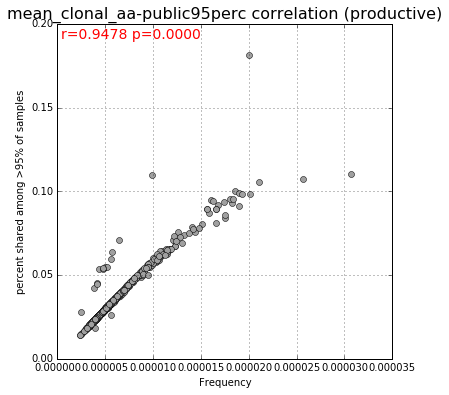

In [153]:
meanClonalAA_public95percCorrFig=draw_correlation_scatter(combined_res_with_tags_df['mean_clonal_aa_df_0'], 
                                                combined_res_with_tags_df['public95perc_df_0'], figsize = (6, 6), 
                                                xticks=None, yticks=None,\
                                                 xlim = None, ylim = None, r = True, ms=6, logd = False,\
                                                 xlab = 'Frequency', ylab = 'percent shared among >95% of samples', 
                                                filename = 'mean_clonal_aa_df_0-public95perc_df_0 correlation', title = 'mean_clonal_aa-public95perc correlation (productive)',
                                                 color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                                                 contour = False)
plt.show()

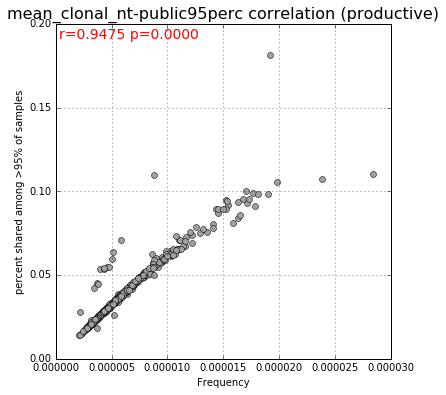

In [154]:
meanClonalNT_public95percCorrFig=draw_correlation_scatter(combined_res_with_tags_df['mean_clonal_nt_df_0'], 
                                                combined_res_with_tags_df['public95perc_df_0'], figsize = (6, 6), 
                                                xticks=None, yticks=None,\
                                                 xlim = None, ylim = None, r = True, ms=6, logd = False,\
                                                 xlab = 'Frequency', ylab = 'percent shared among >95% of samples', 
                                                filename = 'mean_clonal_nt_df_0-public95perc_df_0 correlation', title = 'mean_clonal_nt-public95perc correlation (productive)',
                                                 color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                                                 contour = False)
plt.show()

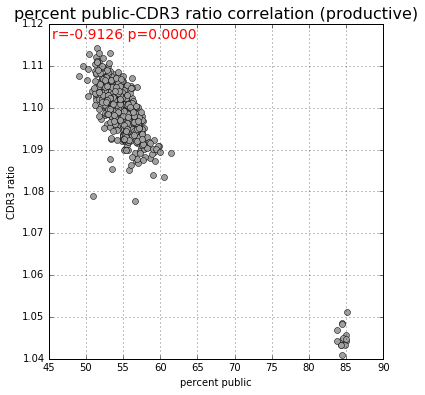

In [155]:
percentPublic_CDR3ratio_prod_corrFig=draw_correlation_scatter(combined_res_with_tags_df['perc_public_df_0'], 
                                                combined_res_with_tags_df['cdr3PriToPub_df_0'], figsize = (6, 6), 
                                                xticks=None, yticks=None,\
                                                 xlim = None, ylim = None, r = True, ms=6, logd = False,\
                                                 xlab = 'percent public', ylab = 'CDR3 ratio', 
                                                filename = 'percent public-CDR3 ratio_prod_corr', title = 'percent public-CDR3 ratio correlation (productive)',
                                                 color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                                                 contour = False)
plt.show()

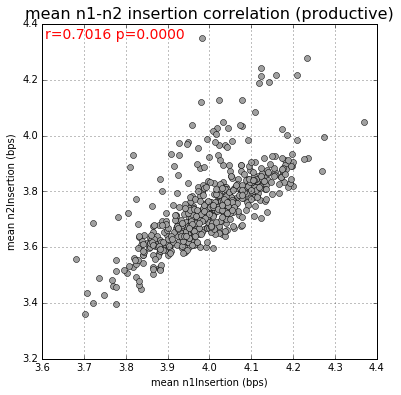

In [161]:
mean_n1_n2_insertion_corr_prod_Fig=draw_correlation_scatter(combined_res_with_tags_df['mean_n1Insertion_df_0'], 
                                                combined_res_with_tags_df['mean_n2Insertion_df_0'], figsize = (6, 6), 
                                                xticks=None, yticks=None,\
                                                 xlim = None, ylim = None, r = True, ms=6, logd = False,\
                                                 xlab = 'mean n1Insertion (bps)', ylab = 'mean n2Insertion (bps)', 
                                                filename = 'mean_n1_n2_insertion_corr_prod', title = 'mean n1-n2 insertion correlation (productive)',
                                                 color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                                                 contour = False)
plt.show()

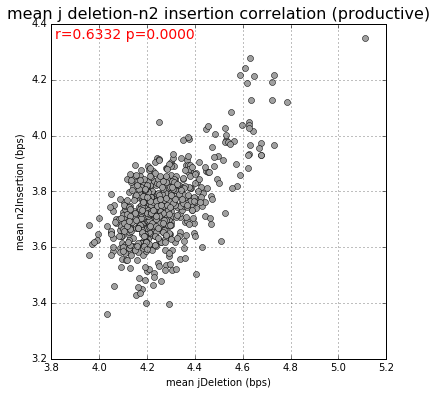

In [162]:
mean_Jdel_N2ins_corr_prod_Fig=draw_correlation_scatter(combined_res_with_tags_df['mean_jDeletion_df_0'], 
                                                combined_res_with_tags_df['mean_n2Insertion_df_0'], figsize = (6, 6), 
                                                xticks=None, yticks=None,\
                                                 xlim = None, ylim = None, r = True, ms=6, logd = False,\
                                                 xlab = 'mean jDeletion (bps)', ylab = 'mean n2Insertion (bps)', 
                                                filename = 'mean_jDEL_n2_insertion_corr_prod', title = 'mean j deletion-n2 insertion correlation (productive)',
                                                 color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                                                 contour = False)
plt.show()

In [170]:
res_corr_df[res_corr_df.index=='mean_cdr3_df_0']

,column2,real_p,real_r,r_perc_2_5,r_perc_97_5,real_p_sig,real_p_sig_corrected,r_outof_CI
column1,,,,,,,,
mean_cdr3_df_0,mean_n1Insertion_df_0,4.576888e-76,0.670520,-0.087785,0.076495,1,1,1
mean_cdr3_df_0,mean_n1Insertion_df_1,1.574016e-64,0.629333,-0.082608,0.068468,1,1,1
mean_cdr3_df_0,cdr3PriToPub95_df_0,1.302943e-56,0.596954,-0.068481,0.081379,1,1,1
mean_cdr3_df_0,mean_vDeletion_df_1,6.250467e-56,-0.593987,-0.065391,0.079266,1,1,1
mean_cdr3_df_0,mean_n2Insertion_df_0,5.555538e-49,0.561825,-0.086640,0.075244,1,1,1
mean_cdr3_df_0,mean_d5Deletion_df_0,1.538497e-27,-0.432646,-0.075815,0.101074,1,1,1
mean_cdr3_df_0,mean_vDeletion_df_0,8.199128e-26,-0.419371,-0.066928,0.115929,1,1,1
mean_cdr3_df_0,mean_d5Deletion_df_1,1.817812e-24,-0.408599,-0.087662,0.059592,1,1,1
mean_cdr3_df_0,sv_n1Insertion_df_0,8.435347e-24,-0.403115,NaN,NaN,1,1,0


## calculating gene usage:

In [272]:
def calc_gene_usage(sample):
    
## stage 1: get sample data
    print sample
    sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample, False)
  
    
## get V-D-J usage data:
   
    
    sample_df_prod=sample_df_prod.replace('unresolved', np.nan)
    sample_df_non_prod=sample_df_non_prod.replace('unresolved', np.nan)
    sample_df_prod['VJfamily']=sample_df_prod['vFamilyName']+'_'+sample_df_prod['jFamilyName']
    sample_df_non_prod['VJfamily']=sample_df_non_prod['vFamilyName']+'_'+sample_df_non_prod['jFamilyName']
    
    var_list=['VJfamily','vGeneName','vFamilyName', 'jGeneName', 'jFamilyName','dGeneName']
    prodDFlist=[]
    nonProdDFlist=[]
    print 'start calculating gene usage percentage...'
    for var in var_list:
        usageFreqProdDF=sample_df_prod.groupby(var)[['frequencyCount (%)']].sum()
        usageFreqProdDF[sample]=usageFreqProdDF['frequencyCount (%)']*100/(usageFreqProdDF['frequencyCount (%)'].sum())
        usageFreqProdDF.drop('frequencyCount (%)', axis=1, inplace=1)
        usageFreqProdDF.index = (usageFreqProdDF.index+'-prod').astype(str)
        usageFreqNonProdDF=sample_df_non_prod.groupby(var)[['frequencyCount (%)']].sum()
        usageFreqNonProdDF[sample]=usageFreqNonProdDF['frequencyCount (%)']*100/(usageFreqNonProdDF['frequencyCount (%)'].sum())
        usageFreqNonProdDF.drop('frequencyCount (%)', axis=1, inplace=1)
        usageFreqNonProdDF.index = (usageFreqNonProdDF.index+'-nonProd').astype(str)
        prodDFlist.append(usageFreqProdDF)
        nonProdDFlist.append(usageFreqNonProdDF)
    print 'finished calculating gene usage percentage'
    return prodDFlist,nonProdDFlist
        

In [277]:
## note! below is a version for sending to the q!!

def combine_gene_usage(n):
    df_file_names,samples_with_df=get_sample_with_dfs()
    VJfamilyProdDF=pd.DataFrame()
    VJfamilyNonProdDF=pd.DataFrame()
    vGeneProdDF=pd.DataFrame()
    vGeneNonProdDF=pd.DataFrame()
    vFamilyProdDF=pd.DataFrame()
    vFamilyNonProdDF=pd.DataFrame()
    jGeneProdDF=pd.DataFrame()
    jGeneNonProdDF=pd.DataFrame()
    jFamilyProdDF=pd.DataFrame()
    jFamilyNonProdDF=pd.DataFrame()
    dGeneProdDF=pd.DataFrame()
    dGeneNonProdDF=pd.DataFrame()
    
    
    for sample in samples_with_df[:n]:
        prodDFlist,nonProdDFlist=calc_gene_usage(sample)
        VJfamilyProdDF=pd.merge(VJfamilyProdDF,prodDFlist[0],how='outer', right_index=True,left_index=True)
        VJfamilyNonProdDF=pd.merge(VJfamilyNonProdDF,nonProdDFlist[0],how='outer', right_index=True,left_index=True)
        vGeneProdDF=pd.merge(vGeneProdDF,prodDFlist[1],how='outer', right_index=True,left_index=True)
        vGeneNonProdDF=pd.merge(vGeneNonProdDF,nonProdDFlist[1],how='outer', right_index=True,left_index=True)
        vFamilyProdDF=pd.merge(vFamilyProdDF,prodDFlist[2],how='outer', right_index=True,left_index=True)
        vFamilyNonProdDF=pd.merge(vFamilyNonProdDF,nonProdDFlist[2],how='outer', right_index=True,left_index=True)
        jGeneProdDF=pd.merge(jGeneProdDF,prodDFlist[3],how='outer', right_index=True,left_index=True)
        jGeneNonProdDF=pd.merge(jGeneNonProdDF,nonProdDFlist[3],how='outer', right_index=True,left_index=True)
        jFamilyProdDF=pd.merge(jFamilyProdDF,prodDFlist[4],how='outer', right_index=True,left_index=True)
        jFamilyNonProdDF=pd.merge(jFamilyNonProdDF,nonProdDFlist[4],how='outer', right_index=True,left_index=True)
        dGeneProdDF=pd.merge(dGeneProdDF,prodDFlist[5],how='outer', right_index=True,left_index=True)
        dGeneNonProdDF=pd.merge(dGeneNonProdDF,nonProdDFlist[5],how='outer', right_index=True,left_index=True)
   
    print len(VJfamilyProdDF.transpose().columns)
    print len(VJfamilyNonProdDF.transpose().columns)
    VJfamilyDF=pd.merge(VJfamilyProdDF.transpose(),VJfamilyNonProdDF.transpose(),how='outer', right_index=True,left_index=True)    
    print len(VJfamilyDF.columns)
    vGeneDF=pd.merge(vGeneProdDF.transpose(),vGeneNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
    vFamilyDF=pd.merge(vFamilyProdDF.transpose(),vFamilyNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
   
    print len(jGeneProdDF.transpose().columns)
    print len(jGeneNonProdDF.transpose().columns)
    jGeneDF=pd.merge(jGeneProdDF.transpose(),jGeneNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
    print len(jGeneDF.columns)
    jFamilyDF=pd.merge(jFamilyProdDF.transpose(),jFamilyNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
    dGeneDF=pd.merge(dGeneProdDF.transpose(),dGeneNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
    
    return VJfamilyDF,vGeneDF,vFamilyDF,jGeneDF,jFamilyDF,dGeneDF
    
        
        
        
    

## sending gene usage analysis to the quese:

In [280]:
import os
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers
import logging 
from Utils import cacheOnDisk

In [294]:
#gene usage calculations: a version for sending to the q:

basePath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage' ## define the path to 

@cacheOnDisk(basePath=basePath, filename='geneUsageDF_%(min_sample)s_%(max_sample)s', force=True)
def combine_gene_usage_q(min_sample, max_sample):
    generate_dfs=False
    print min_sample, max_sample
    if max_sample>573:
        max_sample=573
    n=1
    df_file_names,samples_with_df=get_sample_with_dfs() ## get list of samples with df's
    current_samples=samples_with_df[min_sample:max_sample]
    
    
    VJfamilyProdDF=pd.DataFrame()
    VJfamilyNonProdDF=pd.DataFrame()
    vGeneProdDF=pd.DataFrame()
    vGeneNonProdDF=pd.DataFrame()
    vFamilyProdDF=pd.DataFrame()
    vFamilyNonProdDF=pd.DataFrame()
    jGeneProdDF=pd.DataFrame()
    jGeneNonProdDF=pd.DataFrame()
    jFamilyProdDF=pd.DataFrame()
    jFamilyNonProdDF=pd.DataFrame()
    dGeneProdDF=pd.DataFrame()
    dGeneNonProdDF=pd.DataFrame()
    
    
    for sample in current_samples:
        prodDFlist,nonProdDFlist=calc_gene_usage(sample)
        VJfamilyProdDF=pd.merge(VJfamilyProdDF,prodDFlist[0],how='outer', right_index=True,left_index=True)
        VJfamilyNonProdDF=pd.merge(VJfamilyNonProdDF,nonProdDFlist[0],how='outer', right_index=True,left_index=True)
        vGeneProdDF=pd.merge(vGeneProdDF,prodDFlist[1],how='outer', right_index=True,left_index=True)
        vGeneNonProdDF=pd.merge(vGeneNonProdDF,nonProdDFlist[1],how='outer', right_index=True,left_index=True)
        vFamilyProdDF=pd.merge(vFamilyProdDF,prodDFlist[2],how='outer', right_index=True,left_index=True)
        vFamilyNonProdDF=pd.merge(vFamilyNonProdDF,nonProdDFlist[2],how='outer', right_index=True,left_index=True)
        jGeneProdDF=pd.merge(jGeneProdDF,prodDFlist[3],how='outer', right_index=True,left_index=True)
        jGeneNonProdDF=pd.merge(jGeneNonProdDF,nonProdDFlist[3],how='outer', right_index=True,left_index=True)
        jFamilyProdDF=pd.merge(jFamilyProdDF,prodDFlist[4],how='outer', right_index=True,left_index=True)
        jFamilyNonProdDF=pd.merge(jFamilyNonProdDF,nonProdDFlist[4],how='outer', right_index=True,left_index=True)
        dGeneProdDF=pd.merge(dGeneProdDF,prodDFlist[5],how='outer', right_index=True,left_index=True)
        dGeneNonProdDF=pd.merge(dGeneNonProdDF,nonProdDFlist[5],how='outer', right_index=True,left_index=True)
   
   
    VJfamilyDF=pd.merge(VJfamilyProdDF.transpose(),VJfamilyNonProdDF.transpose(),how='outer', right_index=True,left_index=True)    
    vGeneDF=pd.merge(vGeneProdDF.transpose(),vGeneNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
    vFamilyDF=pd.merge(vFamilyProdDF.transpose(),vFamilyNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
    jGeneDF=pd.merge(jGeneProdDF.transpose(),jGeneNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
    jFamilyDF=pd.merge(jFamilyProdDF.transpose(),jFamilyNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
    dGeneDF=pd.merge(dGeneProdDF.transpose(),dGeneNonProdDF.transpose(),how='outer', right_index=True,left_index=True)
    
    return VJfamilyDF,vGeneDF,vFamilyDF,jGeneDF,jFamilyDF,dGeneDF
    
    

In [ ]:
## sending the 'combine_gene_usage_q' function to the queue in batches:


sethandlers()
os.chdir(basePath)
## the inputs for qp are: jobname, q=machine list, *** add max_r to prevent exploding the cluster!!***
with qp('GeneUsageJob',  q = ['himem7.q','16g.q'], mem_def="10G", trds_def=2, deleteCSHwithnoerr = True, tryrerun = False, max_u=120) as q:
    q.startpermanentrun()
    wait_on =[]
    
##now define a loop that divide the job and send each part seperately:
## consider making a list of integer for the min/max_seq so the first jobs will be shorter than the last ones. 
    min_sample=0
    max_sample=10 
    while  min_sample<573:                                     
        print min_sample
        wait_on.append(q.method(combine_gene_usage_q,kwargs={'min_sample':min_sample,'max_sample':max_sample}))
            ##q.method takes the desired function with its arguments and send it to the queue.
        min_sample=min_sample+10
        max_sample=max_sample+10
    q.wait(wait_on)

##### loading the resulting dfs and combining:

In [296]:
filenames = [f for f in listdir('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/combine_gene_usage_q') if isfile(join('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/combine_gene_usage_q', f))]
#filenames = [datafile for datafile in filenames if datafile.startswith ('HIP') and datafile.endswith('.csv')]
#df_names=[re.sub('.csv', '', datafile) for datafile in filenames]
print filenames
print len(filenames)

['geneUsageDF_310_320', 'geneUsageDF_540_550', 'geneUsageDF_70_80', 'geneUsageDF_160_170', 'geneUsageDF_440_450', 'geneUsageDF_210_220', 'geneUsageDF_80_90', 'geneUsageDF_360_370', 'geneUsageDF_570_580', 'geneUsageDF_30_40', 'geneUsageDF_110_120', 'geneUsageDF_390_400', 'geneUsageDF_470_480', 'geneUsageDF_260_270', 'geneUsageDF_340_350', 'geneUsageDF_20_30', 'geneUsageDF_510_520', 'geneUsageDF_410_420', 'geneUsageDF_170_180', 'geneUsageDF_240_250', 'geneUsageDF_60_70', 'geneUsageDF_560_570', 'geneUsageDF_370_380', 'geneUsageDF_270_280', 'geneUsageDF_460_470', 'geneUsageDF_140_150', 'geneUsageDF_40_50', 'geneUsageDF_90_100', 'geneUsageDF_200_210', 'geneUsageDF_450_460', 'geneUsageDF_0_10', 'geneUsageDF_130_140', 'geneUsageDF_550_560', 'geneUsageDF_300_310', 'geneUsageDF_180_190', 'geneUsageDF_290_300', 'geneUsageDF_380_390', 'geneUsageDF_100_110', 'geneUsageDF_420_430', 'geneUsageDF_330_340', 'geneUsageDF_230_240', 'geneUsageDF_280_290', 'geneUsageDF_520_530', 'geneUsageDF_250_260', 'ge

In [310]:
VJfamilyComblist=[]
vGeneComblist=[]
vFamilyComblist=[]
jGeneComblist=[]
jFamilyComblist=[]
dGeneComblist=[]

for file in filenames:
    with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/combine_gene_usage_q/%s' %file, 'rb') as f:
        allDFs=pickle.load(f)
    f.close()
    VJfamilyComblist.append(allDFs[0])
    vGeneComblist.append(allDFs[1])
    vFamilyComblist.append(allDFs[2])
    jGeneComblist.append(allDFs[3])
    jFamilyComblist.append(allDFs[4])
    dGeneComblist.append(allDFs[5])

VJfamilyCombDF=pd.concat(VJfamilyComblist)
vGeneCombDF=pd.concat(vGeneComblist)
vFamilyCombDF=pd.concat(vFamilyComblist)
jGeneCombDF=pd.concat( jGeneComblist)
jFamilyCombDF=pd.concat(jFamilyComblist)
dGeneCombDF=pd.concat(dGeneComblist)






print len(VJfamilyCombDF)
print len(vGeneCombDF)

573
573


In [394]:
geneUsageAllDF=pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(VJfamilyCombDF,vGeneCombDF,how='outer', 
                                                     right_index=True,left_index=True), vFamilyCombDF,how='outer',
                                                      right_index=True,left_index=True),jGeneCombDF, how='outer',
                                                      right_index=True,left_index=True),jFamilyCombDF, how='outer',
                                                      right_index=True,left_index=True),dGeneCombDF,how='outer',
                                                      right_index=True,left_index=True)

In [395]:
print len(geneUsageAllDF)
print len(geneUsageAllDF.columns. values)

573
354


In [396]:
geneUsageAllDF.head()

,TCRBV01_TCRBJ01-nonProd,TCRBV01_TCRBJ01-prod,TCRBV01_TCRBJ02-nonProd,TCRBV01_TCRBJ02-prod,TCRBV02_TCRBJ01-nonProd,TCRBV02_TCRBJ01-prod,TCRBV02_TCRBJ02-nonProd,TCRBV02_TCRBJ02-prod,TCRBV03_TCRBJ01-nonProd,TCRBV03_TCRBJ01-prod,...,TCRBJ02-06-nonProd,TCRBJ02-07-nonProd,TCRBJ01-prod,TCRBJ02-prod,TCRBJ01-nonProd,TCRBJ02-nonProd,TCRBD01-01-prod,TCRBD02-01-prod,TCRBD01-01-nonProd,TCRBD02-01-nonProd
HIP12097,0.056391,0.014303,0.227544,0.020919,0.269138,1.562619,2.145351,1.466474,0.834792,0.843583,...,1.344502,23.882634,38.959926,61.040074,37.465947,62.534053,47.986009,52.013991,35.315949,64.684051
HIP13256,0.145131,0.009651,0.203607,0.019302,0.717548,2.717355,0.834888,1.965018,1.389936,1.425341,...,2.283331,14.608366,52.370985,47.629015,51.691781,48.308219,58.313281,41.686719,57.978373,42.021627
HIP12533,0.165867,0.009326,0.491296,0.043449,0.618799,2.517324,1.200240,2.443481,0.669773,1.794747,...,1.942208,28.171729,45.314730,54.685270,38.030878,61.969122,49.541865,50.458135,44.500042,55.499958
HIP14138,0.192601,0.033074,0.366617,0.036199,0.987711,2.522818,0.942320,1.857738,1.411148,1.886235,...,1.911376,18.114246,53.473823,46.526177,55.483248,44.516752,54.778342,45.221658,55.239131,44.760869
HIP15855,0.102349,0.011409,0.305760,0.028594,0.370275,1.469477,0.781860,1.663565,1.376452,1.597125,...,1.800727,28.605713,42.996128,57.003872,36.536257,63.463743,52.341248,47.658752,49.151402,50.848598


In [404]:
geneUsageAllDF['TCRBV01_TCRBJ01-nonProd'].describe()

count    573.000000
mean       0.238386
std        0.739091
min        0.036818
25%        0.124837
50%        0.165567
75%        0.214728
max       15.287116
Name: TCRBV01_TCRBJ01-nonProd, dtype: float64

In [299]:
VJfamilyCombDF.head()

,TCRBV01_TCRBJ01-nonProd,TCRBV01_TCRBJ01-prod,TCRBV01_TCRBJ02-nonProd,TCRBV01_TCRBJ02-prod,TCRBV02_TCRBJ01-nonProd,TCRBV02_TCRBJ01-prod,TCRBV02_TCRBJ02-nonProd,TCRBV02_TCRBJ02-prod,TCRBV03_TCRBJ01-nonProd,TCRBV03_TCRBJ01-prod,...,TCRBV29_TCRBJ02-nonProd,TCRBV29_TCRBJ02-prod,TCRBV30_TCRBJ01-nonProd,TCRBV30_TCRBJ01-prod,TCRBV30_TCRBJ02-nonProd,TCRBV30_TCRBJ02-prod,TCRBVA_TCRBJ01-nonProd,TCRBVA_TCRBJ01-prod,TCRBVA_TCRBJ02-nonProd,TCRBVA_TCRBJ02-prod
HIP12097,0.056391,0.014303,0.227544,0.020919,0.269138,1.562619,2.145351,1.466474,0.834792,0.843583,...,0.514859,0.869976,0.419494,1.204679,0.450603,1.124187,0.009962,0.000587,0.005534,0.000998
HIP13256,0.145131,0.009651,0.203607,0.019302,0.717548,2.717355,0.834888,1.965018,1.389936,1.425341,...,0.549837,0.779250,0.755183,1.047405,0.426515,0.670051,0.012931,0.000333,0.013510,0.000666
HIP12533,0.165867,0.009326,0.491296,0.043449,0.618799,2.517324,1.200240,2.443481,0.669773,1.794747,...,0.689759,0.905774,0.661522,1.163110,0.708473,0.775945,0.006573,0.001406,0.016902,NaN
HIP14138,0.192601,0.033074,0.366617,0.036199,0.987711,2.522818,0.942320,1.857738,1.411148,1.886235,...,0.606744,0.717018,0.505105,0.043407,0.461458,0.027220,0.003453,0.000874,0.001566,NaN
HIP15855,0.102349,0.011409,0.305760,0.028594,0.370275,1.469477,0.781860,1.663565,1.376452,1.597125,...,0.588258,0.837322,0.557317,1.117629,0.505919,0.769413,0.017264,0.000438,0.016255,0.001816


In [300]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/VJfamilyCombDF','wb') as f:
    pickle.dump(VJfamilyCombDF, f)
f.close()

In [301]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/vGeneCombDF','wb') as f:
    pickle.dump(vGeneCombDF, f)
f.close()

In [302]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/vFamilyCombDF','wb') as f:
    pickle.dump(vFamilyCombDF, f)
f.close()

In [303]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/jGeneCombDF','wb') as f:
    pickle.dump(jGeneCombDF, f)
f.close()

In [332]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/jFamilyCombDF','wb') as f:
    pickle.dump(jFamilyCombDF, f)
f.close()

In [305]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/dGeneCombDF','wb') as f:
    pickle.dump(dGeneCombDF, f)
f.close()

In [307]:
jFamilyCombCombDF.head()

,TCRBJ01-prod,TCRBJ02-prod,TCRBJ01-nonProd,TCRBJ02-nonProd
HIP12097,38.959926,61.040074,37.465947,62.534053
HIP13256,52.370985,47.629015,51.691781,48.308219
HIP12533,45.314730,54.685270,38.030878,61.969122
HIP14138,53.473823,46.526177,55.483248,44.516752
HIP15855,42.996128,57.003872,36.536257,63.463743


#### plotting and comparing productive and non-productive sequence in the population level:

In [405]:
def get_geneUsage_data(CombDF):
    dfdescribe=CombDF.describe()
    
    usageList=[name.replace('-prod','').replace('-nonProd','') for name in dfdescribe.columns.values]
    usageSet=set(usageList)
    prod_means=[]
    prod_stds=[]
    non_prod_means=[]
    non_prod_stds=[]
    ttest_p_list=[]
    oneColList=[]
    n=0
    print len(CombDF.columns.values)
    for name in usageSet:
        cols=[column for column in dfdescribe.columns.values if column.startswith(name)]
        if len(cols)==2:
            column1=cols[0]
            column2=cols[1]
            t, p=stats.ttest_ind(CombDF[column1], CombDF[column2], nan_policy='omit')
            ttest_p_list.append(p)
            for col in cols:
                if col.endswith('-prod'):
                    prod_means.append(dfdescribe.loc['mean',col])
                    prod_stds.append(dfdescribe.loc['std',col])
                else:
                    non_prod_means.append(dfdescribe.loc['mean',col])
                    non_prod_stds.append(dfdescribe.loc['std',col])
            n=n+1
        elif len(cols)==1:
            print name
            print cols
            ttest_p_list.append(np.nan)
            oneColList.append(cols[0])
            if cols[0].endswith('-prod'):
                prod_means.append(dfdescribe.loc['mean',cols[0]])
                prod_stds.append(dfdescribe.loc['std',cols[0]])
                non_prod_means.append(0)
                non_prod_stds.append(0)
            else:
                non_prod_means.append(dfdescribe.loc['mean',cols[0]])
                non_prod_stds.append(dfdescribe.loc['std',cols[0]])
                prod_means.append(0)
                prod_stds.append(0)


    print n
    usageSumDF=pd.DataFrame({'name': list(usageSet),'prod_means': prod_means,
                                'prod_means': prod_means,'prod_stds':prod_stds, 
                                'non_prod_means':non_prod_means,'non_prod_stds':non_prod_stds,
                               'ttest-p value':ttest_p_list })
    usageSumDF['Sig']=np.where(usageSumDF['ttest-p value']<0.05/len(usageSumDF.index), 1, 0)
    usageSumDF.set_index('name', inplace=1)  
    usageSumDF.sort('prod_means',ascending=False,inplace=1)
    
    return usageSumDF, oneColList

    

In [435]:
def plot_geneUsage_data(usageSumDF,usageType,yscale):
    usageSumDFFig = plt.figure(figsize = (14,6))

    space = 0.3
    width = (1 - space) / 2
    xticks=range(len(usageSumDF.index))
    pos_prod = [i - 0.5*width for i in xticks]
    pos_non_prod = [i + 0.5*width for i in xticks]


    plt.bar(pos_prod, usageSumDF['prod_means'], yerr=usageSumDF['prod_stds'], color='blue',
            ecolor='blue',label='Productive', width=width)
    plt.bar(pos_non_prod, usageSumDF['non_prod_means'], yerr=usageSumDF['non_prod_stds'], color='red',
            ecolor='red',label='Non Productive', width=width)
    plt.xticks(xticks,usageSumDF.index,rotation=90)
    plt.xlim(-1,len(usageSumDF.index)+1)
    plt.legend(loc='best')
    plt.title('%s usage (%s scale)' %(usageType, yscale), fontsize=16)
    #plt.xlabel('Gender')
    plt.ylabel('percent', fontsize=12)
    plt.yscale(yscale)
    file_name='%s usage-%s scale' %(usageType, yscale)
    usageSumDFFig.savefig(file_name, bbox_inches='tight', dpi = 800)
    #GenderOnMeanSharedSamplesProdFig.savefig('GenderOnMeanSharedSamplesProdFig', bbox_inches='tight', dpi = 800)
    plt.show()

In [407]:
VJfamilyusageSumDF, VJoneColList=get_geneUsage_data(VJfamilyCombDF)


124
62


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [315]:
VJfamilyusageSumDF.head()

,non_prod_means,non_prod_stds,prod_means,prod_stds,ttest-p value,Sig
name,,,,,,
TCRBV06_TCRBJ02,9.482979,3.481444,10.000779,2.573421,4.273155e-03,0
TCRBV06_TCRBJ01,7.863745,3.087740,8.941324,2.042349,5.431627e-12,1
TCRBV05_TCRBJ02,5.648042,1.742082,6.702921,1.349494,7.437869e-29,1
TCRBV07_TCRBJ02,5.695025,2.056045,6.051045,1.489604,8.150157e-04,0
TCRBV05_TCRBJ01,5.352485,2.583528,5.778962,1.418468,5.524114e-04,1


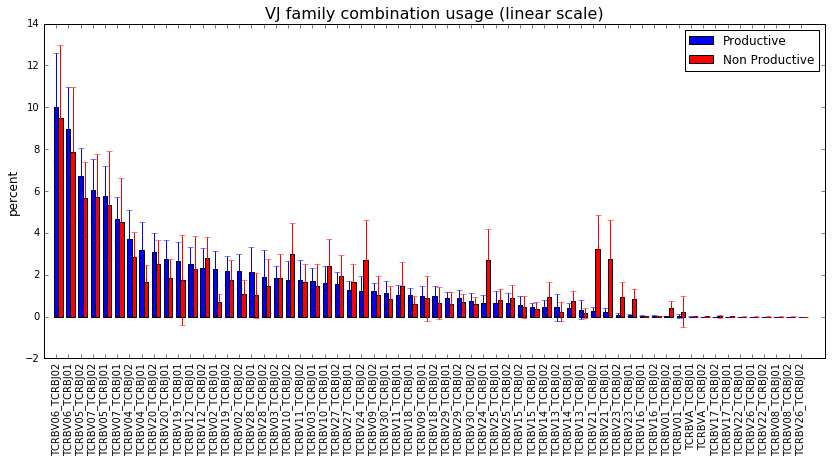

In [436]:
plot_geneUsage_data(VJfamilyusageSumDF,'VJ family combination','linear')

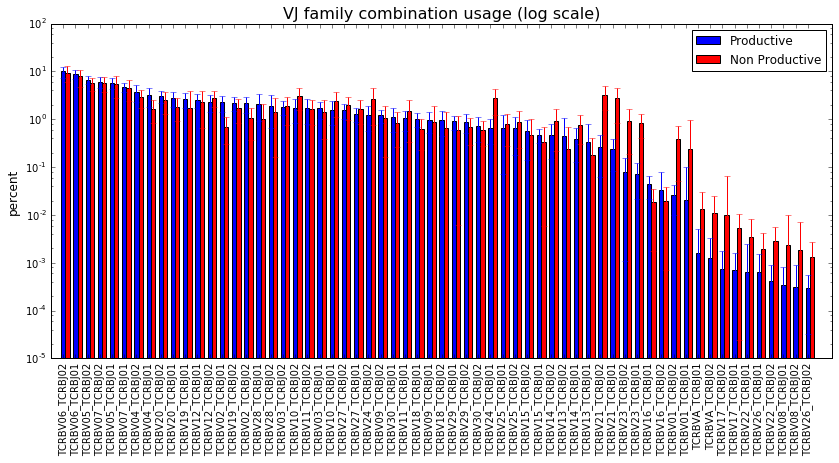

In [437]:
plot_geneUsage_data(VJfamilyusageSumDF,'VJ family combination','log')

In [408]:
vGeneUsageSumDF,VgeneoneColList=get_geneUsage_data(vGeneCombDF)
VgeneoneColList


134
67


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[]

In [409]:
VfamilyusageSumDF,VfamilyoneColList=get_geneUsage_data(vFamilyCombDF)
VfamilyoneColList

62
31


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[]

In [410]:
jGeneUsageSumDF,jGeneoneColList=get_geneUsage_data(jGeneCombDF)
jGeneoneColList

26
13


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[]

In [411]:
jFamilyUsageSumDF,jfamilyoneColList=get_geneUsage_data(jFamilyCombDF)
jfamilyoneColList

4
2


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[]

In [420]:
dGeneUsageSumDF,dGeneoneColList=get_geneUsage_data(dGeneCombDF)


4
2


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


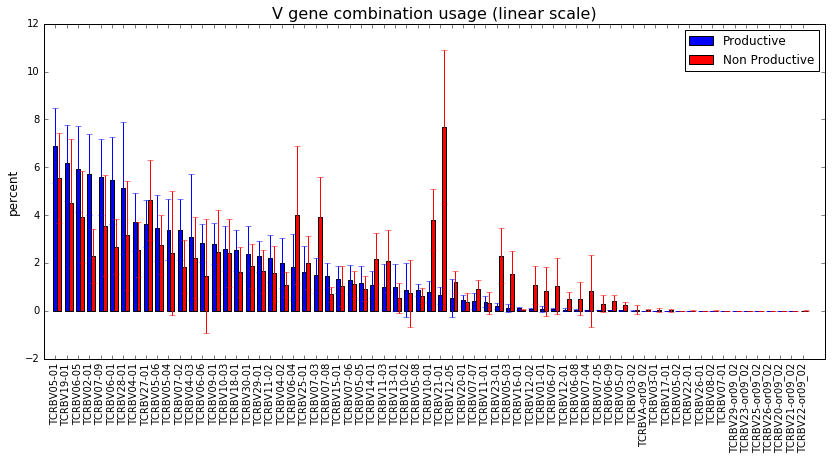

In [438]:
plot_geneUsage_data(vGeneUsageSumDF,'V gene combination','linear')

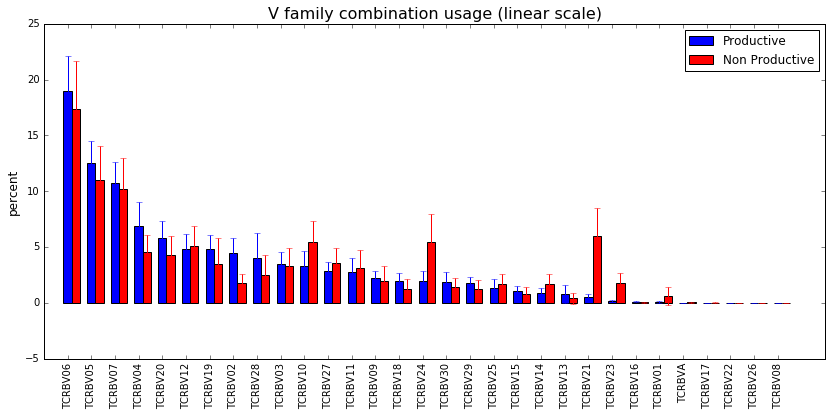

In [439]:
plot_geneUsage_data(VfamilyusageSumDF,'V family combination','linear')

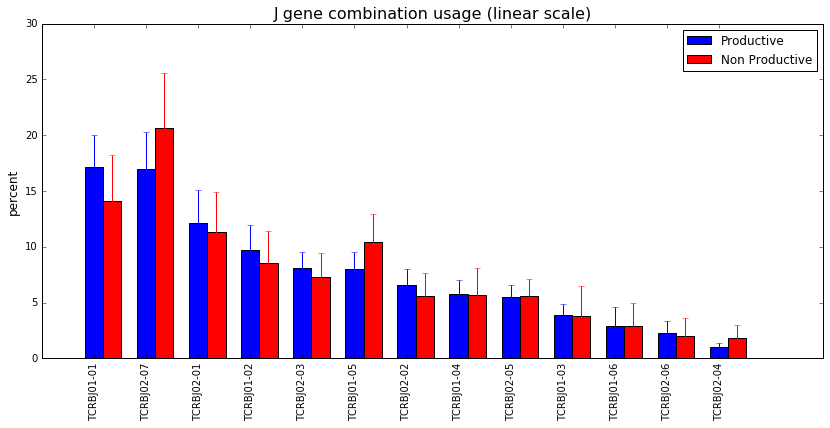

In [440]:
plot_geneUsage_data(jGeneUsageSumDF,'J gene combination','linear')

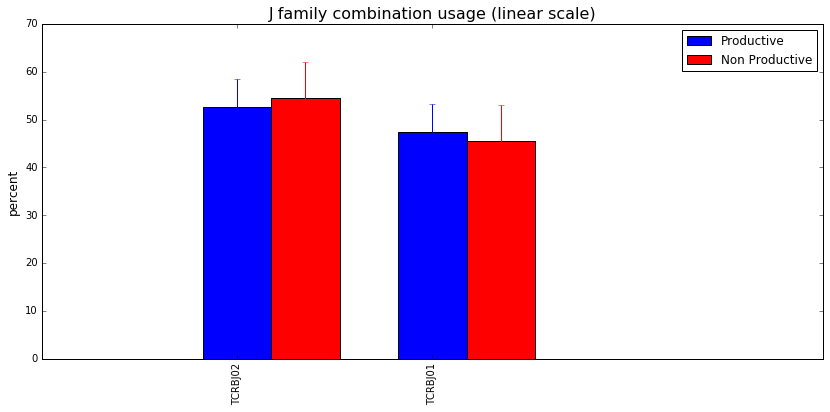

In [441]:
plot_geneUsage_data(jFamilyUsageSumDF,'J family combination','linear')

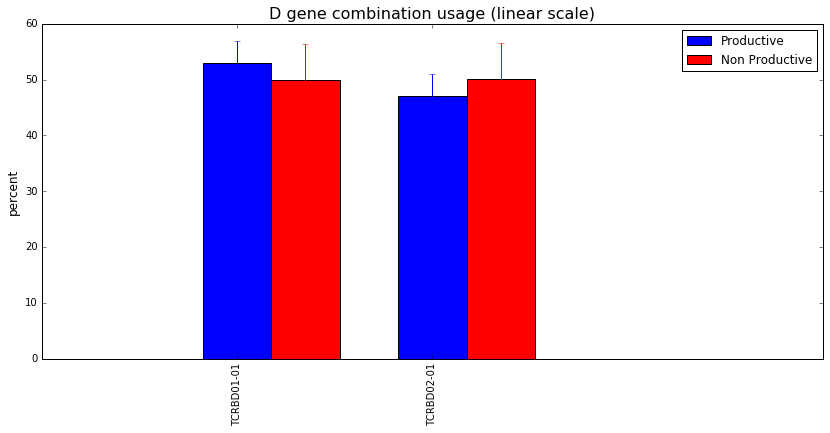

In [442]:
plot_geneUsage_data(dGeneUsageSumDF,'D gene combination','linear')

In [421]:
combinedUsageDF=pd.concat([VJfamilyusageSumDF,vGeneUsageSumDF, VfamilyusageSumDF,jGeneUsageSumDF,
                           jFamilyUsageSumDF,dGeneUsageSumDF])

In [422]:
combinedUsageDF.sort('ttest-p value',inplace=1)

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [424]:
print len(combinedUsageDF)
print len(combinedUsageDFSig)

177
143


In [450]:
x=143.0/177
x

0.807909604519774

In [434]:
combinedUsageDF[120:]

,non_prod_means,non_prod_stds,prod_means,prod_stds,ttest-p value,Sig
name,,,,,,
TCRBV05-05,0.919001,0.513897,1.153988,0.718657,2.78935e-10,1
TCRBV13_TCRBJ02,0.233720,0.444701,0.440390,0.638336,2.92786e-10,1
TCRBV16_TCRBJ02,0.019698,0.019003,0.032634,0.044976,3.59674e-10,1
TCRBV28_TCRBJ02,1.446895,1.287007,1.910697,1.260709,9.91136e-10,1
TCRBV22-or09_02,0.006351,0.008502,0.000091,NaN,--,0
TCRBV07-06,1.100827,0.550623,1.303463,0.602711,3.73906e-09,1
TCRBV30_TCRBJ02,0.604826,0.326182,0.733594,0.404281,3.91821e-09,1
TCRBV25-01,2.003073,1.104891,1.630650,1.059776,7.50402e-09,1
TCRBJ01,45.494885,7.524760,47.414356,5.901982,1.75689e-06,1


In [423]:
combinedUsageDFSig=combinedUsageDF[combinedUsageDF['Sig']==1]
combinedUsageDFSig

,non_prod_means,non_prod_stds,prod_means,prod_stds,ttest-p value,Sig
name,,,,,,
TCRBV10-01,3.814512,1.285917,0.785164,0.439504,1.05448e-312,1
TCRBV21-01,7.697254,3.217020,0.641618,0.346451,6.08092e-305,1
TCRBV21,5.963734,2.561991,0.501699,0.270283,3.4587e-295,1
TCRBV05-07,0.253748,0.117537,0.017194,0.018656,1.98199e-273,1
TCRBV23,1.783885,0.855823,0.150417,0.092740,2.42683e-258,1
TCRBV23-01,2.305978,1.141123,0.192238,0.120034,5.68371e-249,1
TCRBV21_TCRBJ02,3.229813,1.628967,0.265019,0.203957,8.40537e-243,1
TCRBV23_TCRBJ01,0.851611,0.444884,0.071717,0.050583,8.33738e-232,1
TCRBV02,1.765516,0.810000,4.465597,1.337219,2.9098e-229,1


In [350]:
combinedUsageDFSig

,non_prod_means,non_prod_stds,prod_means,prod_stds,ttest-p value,Sig
name,,,,,,


In [425]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/combinedUsageDF','wb') as f:
    pickle.dump(combinedUsageDF, f)
f.close()

In [443]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/geneUsageAllDF','wb') as f:
    pickle.dump(geneUsageAllDF, f)
f.close()

In [448]:
  geneUsageAllDF['TCRBV11-01-prod'].describe()

count    573.000000
mean       0.379715
std        0.236302
min        0.007255
25%        0.231775
50%        0.330179
75%        0.477886
max        2.248476
Name: TCRBV11-01-prod, dtype: float64

In [451]:
geneUsageAllDF.head()

,TCRBV01_TCRBJ01-nonProd,TCRBV01_TCRBJ01-prod,TCRBV01_TCRBJ02-nonProd,TCRBV01_TCRBJ02-prod,TCRBV02_TCRBJ01-nonProd,TCRBV02_TCRBJ01-prod,TCRBV02_TCRBJ02-nonProd,TCRBV02_TCRBJ02-prod,TCRBV03_TCRBJ01-nonProd,TCRBV03_TCRBJ01-prod,...,TCRBJ02-06-nonProd,TCRBJ02-07-nonProd,TCRBJ01-prod,TCRBJ02-prod,TCRBJ01-nonProd,TCRBJ02-nonProd,TCRBD01-01-prod,TCRBD02-01-prod,TCRBD01-01-nonProd,TCRBD02-01-nonProd
HIP12097,0.056391,0.014303,0.227544,0.020919,0.269138,1.562619,2.145351,1.466474,0.834792,0.843583,...,1.344502,23.882634,38.959926,61.040074,37.465947,62.534053,47.986009,52.013991,35.315949,64.684051
HIP13256,0.145131,0.009651,0.203607,0.019302,0.717548,2.717355,0.834888,1.965018,1.389936,1.425341,...,2.283331,14.608366,52.370985,47.629015,51.691781,48.308219,58.313281,41.686719,57.978373,42.021627
HIP12533,0.165867,0.009326,0.491296,0.043449,0.618799,2.517324,1.200240,2.443481,0.669773,1.794747,...,1.942208,28.171729,45.314730,54.685270,38.030878,61.969122,49.541865,50.458135,44.500042,55.499958
HIP14138,0.192601,0.033074,0.366617,0.036199,0.987711,2.522818,0.942320,1.857738,1.411148,1.886235,...,1.911376,18.114246,53.473823,46.526177,55.483248,44.516752,54.778342,45.221658,55.239131,44.760869
HIP15855,0.102349,0.011409,0.305760,0.028594,0.370275,1.469477,0.781860,1.663565,1.376452,1.597125,...,1.800727,28.605713,42.996128,57.003872,36.536257,63.463743,52.341248,47.658752,49.151402,50.848598


In [1]:
print 'hello'

hello


In [2]:
import seaborn as sns

In [3]:
sns.set()

In [56]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/vFamilyCombDF','rb') as f:
    vFamilyCombDF=pickle.load(f)
f.close()

In [57]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/jGeneCombDF','rb') as f:
    jGeneCombDF=pickle.load(f)
f.close()

In [58]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/jFamilyCombDF','rb') as f:
    jFamilyCombDF=pickle.load(f)
f.close()

In [59]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/vGeneCombDF','rb') as f:
    vGeneCombDF=pickle.load(f)
f.close()

In [60]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/dGeneCombDF','rb') as f:
    dGeneCombDF=pickle.load(f)
f.close()

In [61]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/geneUsage/VJfamilyCombDF','rb') as f:
    VJfamilyCombDF=pickle.load(f)
f.close()

In [62]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_tags','rb') as f:
    sample_tags=pickle.load(f)
f.close()

In [10]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_tags','wb') as f:
    pickle.dump(sample_tags,f)
f.close()

In [17]:
current_palette=sns.color_palette("hls", 8)
#color_palette("Set2", 6))
#current_palette

In [66]:
'''
this function takes the usageDF and generates a clustermap.
the row labels can be according to gender or age groups, choose 'Gender' or 'AgeGroup' as row_cluster.
usagetype-a string with the gene/family/combination type (V family, J gene etc.)
'''

def gen_clustermap(usageDF,usageType, row_cluster):
    usageDF=usageDF.fillna(0)
    with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_tags','rb') as f:
        sample_tags=pickle.load(f)
    f.close()
       
    colors = {'young':current_palette[3], 'adult':current_palette[6], 'old':current_palette[7], 'nan':'white',
              'Female':current_palette[1],'Male': current_palette[2], 0:'white'}
    col_colors=pd.DataFrame({'columns': usageDF.columns.values, 
                  'prod/nonProd': (pd.Series(usageDF.columns.values)).apply(lambda x:define_prod(x))}).set_index('columns')
    row_colors=row_colors=sample_tags[row_cluster].apply(lambda x: colors[x])
    
    figWidth=float(len(usageDF.columns.values))/3
    fig = sns.clustermap(usageDF, row_colors=row_colors, col_colors=col_colors,figsize=(figWidth,25))
    plt.setp(fig.ax_heatmap.get_yticklabels(), rotation=0,fontsize=3)  # For y axis
    plt.show()
    file_name='%s clustermap by %s' %(usageType, row_cluster)
    fig.savefig(file_name, bbox_inches='tight', dpi = 800)
    return fig


In [54]:
def define_prod(x):
    if 'nonProd' in str(x):
        return 'red'
    else:
        return 'blue'

define_prod('TCRBV01-nonProd')    

'red'

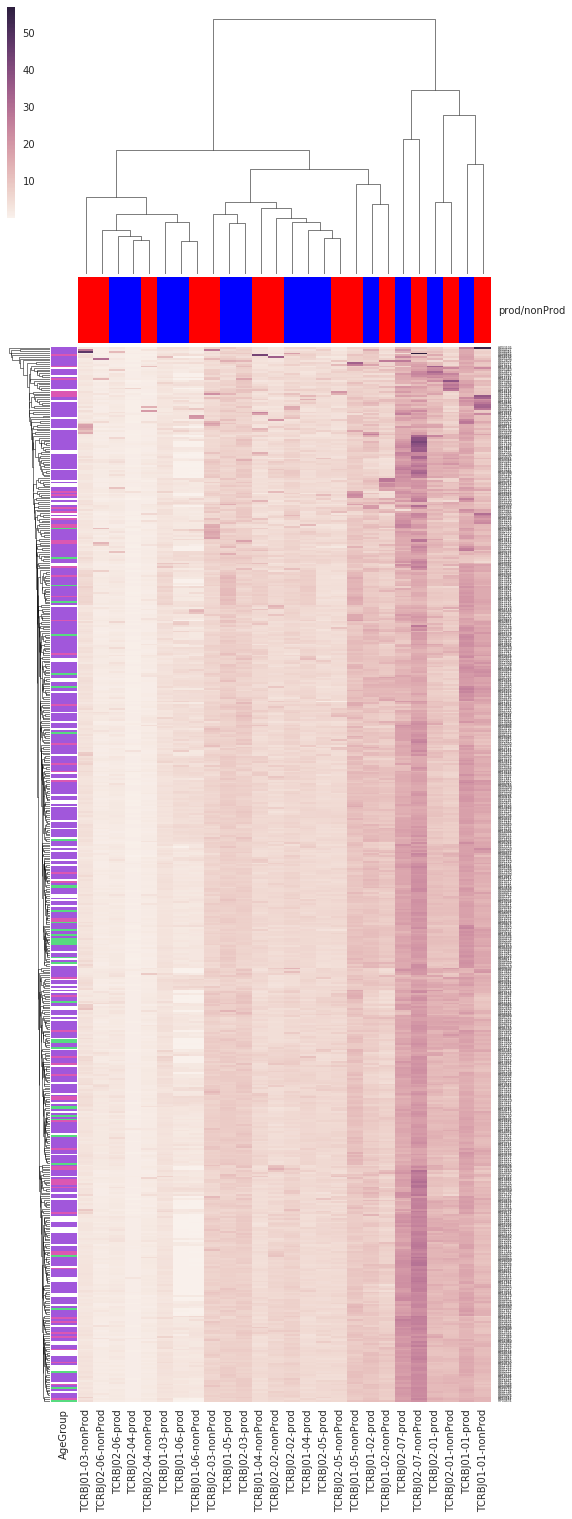

In [67]:
gen_clustermap(jGeneCombDF,'J gene','AgeGroup')


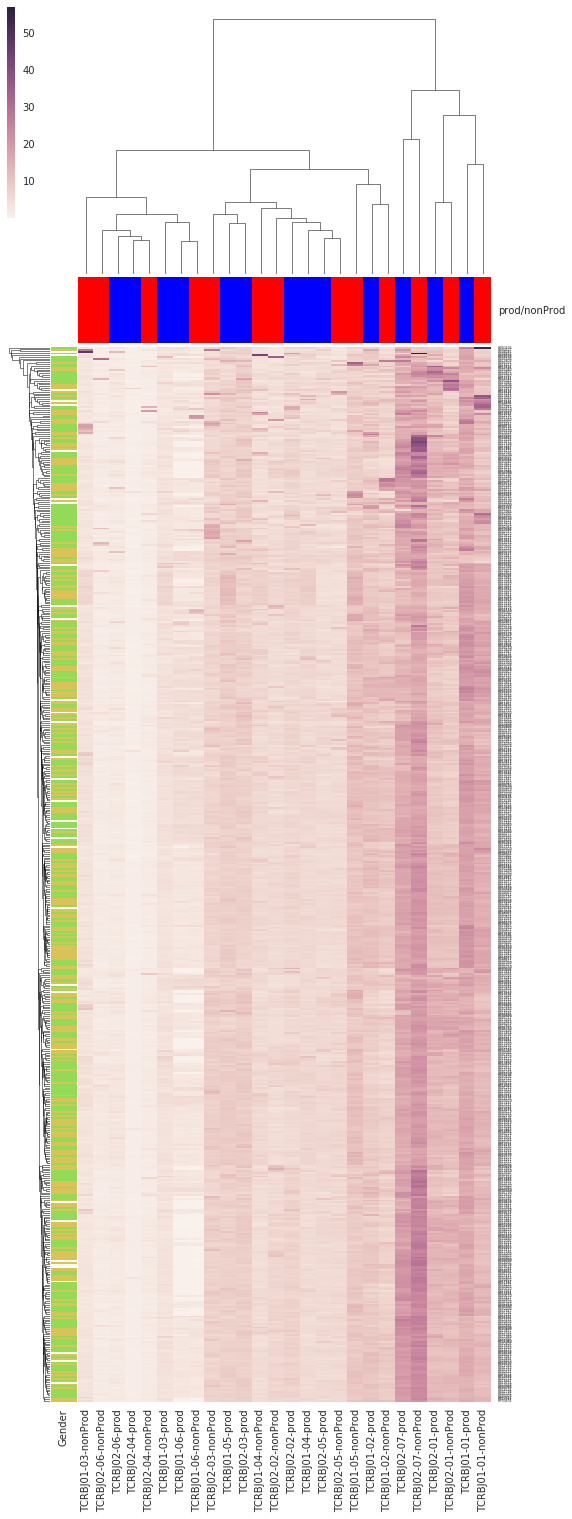

In [68]:
gen_clustermap(jGeneCombDF,'J gene','Gender')


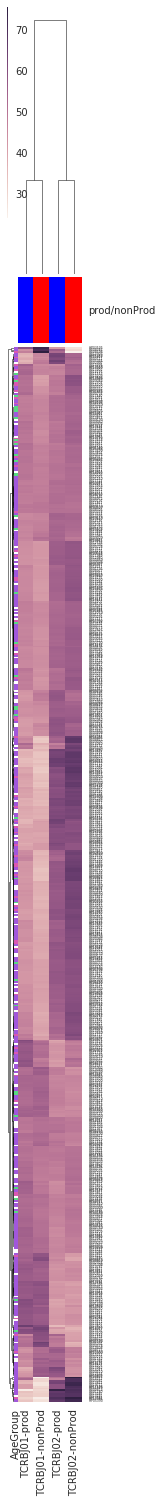

In [69]:
gen_clustermap(jFamilyCombDF,'J family','AgeGroup')


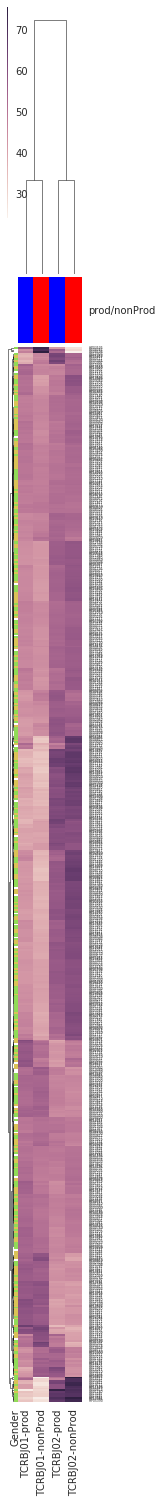

In [70]:
gen_clustermap(jFamilyCombDF,'J family','Gender')


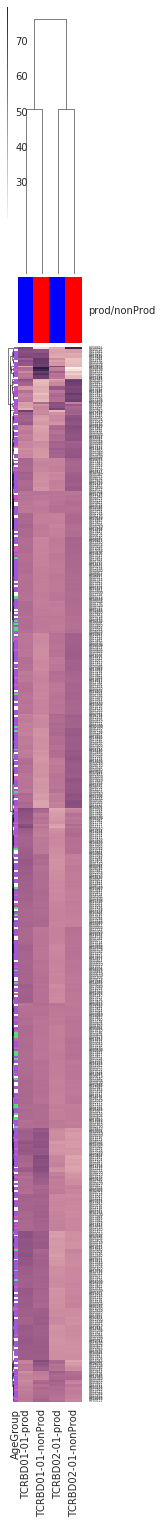

In [71]:
gen_clustermap(dGeneCombDF,'D gene','AgeGroup')


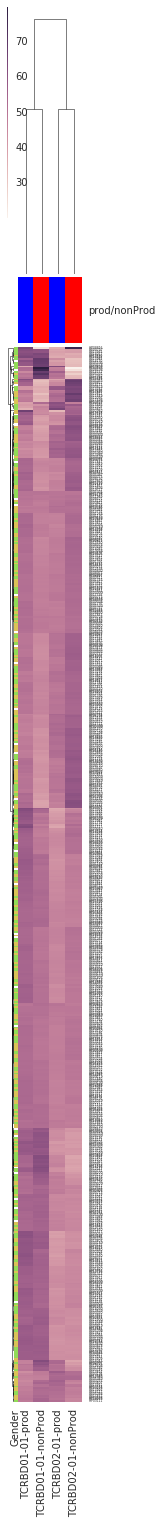

In [72]:
gen_clustermap(dGeneCombDF,'D gene','Gender')


In [ ]:
gen_clustermap(vGeneCombDF,'V gene','AgeGroup')


In [ ]:
gen_clustermap(vGeneCombDF,'V gene','Gender')


In [ ]:
gen_clustermap(vFamilyCombDF,'V family','AgeGroup')


In [ ]:
gen_clustermap(vFamilyCombDF,'V family','Gender')


In [ ]:
gen_clustermap(VJfamilyCombDF,'VJ family','AgeGroup')


In [ ]:
gen_clustermap(VJfamilyCombDF,'VJ family','Gender')


In [7]:
sample_df, sample_df_prod, sample_df_non_prod=get_sample_data('HIP00110', False)

getting sample data...
finished getting sample data


In [8]:
sample_df_prod.head()

,nucleotide,aminoAcid,count (reads),frequencyCount (%),cdr3Length,vMaxResolved,vFamilyName,vGeneName,vGeneAllele,vFamilyTies,...,estimatedNumberGenomes,sequenceStatus,cloneResolved,vOrphon,dOrphon,jOrphon,vFunction,dFunction,jFunction,fractionNucleated
1,GCTACCAGCTCCCAGACATCTGTGTACTTCTGTGCCACCACGGGTA...,CATTGTSGGPSQSTQYF,44434,1.094612,51,TCRBV10-03*01,TCRBV10,TCRBV10-03,1.0,NaN,...,1772,In,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.004399
2,ATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCA...,CASSLRVGGYGYTF,44008,1.084118,42,TCRBV07-09,TCRBV07,TCRBV07-09,NaN,NaN,...,1763,In,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.004357
4,GAGTCTGCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCA...,CASRRLGGLNTEAFF,24883,0.612982,45,TCRBV25-01*01,TCRBV25,TCRBV25-01,1.0,NaN,...,985,In,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.002464
5,GTGAGCACCTTGGAGCTGGGGGACTCGGCCCTTTATCTTTGCGCCA...,CASSLRGSGNTIYF,14247,0.350969,42,TCRBV05-01*01,TCRBV05,TCRBV05-01,1.0,NaN,...,566,In,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.001411
6,AGGCTGGAGTCGGCTGCTCCCTCCCAGACATCTGTGTACTTCTGTG...,CASRQDGSTEAFF,12943,0.318845,39,TCRBV06-01*01,TCRBV06,TCRBV06-01,1.0,NaN,...,506,In,VDJ,NaN,NaN,NaN,NaN,NaN,NaN,0.001282


In [9]:
def norm_uniqe_nt_sequences(df, **kwargs): 
    repeats=10
    samp_size=100000
    reads=list(df['count (reads)'])
    df=df.set_index('nucleotide')
    seqs=[str(i) for i in list(df.index)]
    n_seqs=len(seqs)
    total_reads=np.sum(reads)
    print ('number of sequences= %s' %n_seqs)
    print ('total number of reads= %s' %total_reads)
    seq_popped=[]
    for i in range(0,len(seqs)):
        for j in range(0,reads[i]):
            seq_popped.append(seqs[i])        
    seq_n_list=[]
    for t in range(repeats):
        rand_seq=np.random.choice(seq_popped, samp_size, replace=False)
        seq_n=len(set(rand_seq))
        seq_n_list.append(seq_n)
    print seq_n_list
    mean_seq_n=np.mean(seq_n_list)
    return mean_seq_n     

In [10]:
mean_seq_n=norm_uniqe_nt_sequences(sample_df_prod)

number of sequences= 104850
total number of reads= 3238889
[44213, 43870, 43875, 44007, 43909, 43763, 44249, 43889, 44183, 44150]


In [11]:
mean_seq_n

44010.800000000003

In [12]:
sample_df, sample_df_prod, sample_df_non_prod=get_sample_data('HIP14000', False)

getting sample data...
finished getting sample data


In [13]:
mean_seq_n=norm_uniqe_nt_sequences(sample_df_prod)

number of sequences= 469797
total number of reads= 7479358
[81715, 81841, 81735, 81711, 81852, 81985, 81891, 81879, 81552, 81712]


In [14]:
mean_seq_n

81787.300000000003

In [15]:
sample_df, sample_df_prod, sample_df_non_prod=get_sample_data('HIP13754', False)

getting sample data...
finished getting sample data


In [16]:
mean_seq_n=norm_uniqe_nt_sequences(sample_df_prod)

number of sequences= 252397
total number of reads= 3100423
[70226, 70136, 70086, 70175, 70173, 70171, 70141, 70316, 70075, 70376]


In [17]:
mean_seq_n

70187.5

In [3]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/combined_res_with_tags_df_08032017', 'rb') as f:
    combined_res_with_tags_df_08032017=pickle.load(f)
f.close()

In [5]:
combined_res_with_tags_df_08032017['unique_aa_n_df_0'].describe()

#['unique_aa_n_df_1'].describe()

count       573.000000
mean     190153.650960
std       71224.376475
min       32555.000000
25%      142200.000000
50%      188920.000000
75%      240657.000000
max      415509.000000
Name: unique_aa_n_df_0, dtype: float64

In [6]:
np.percentile(combined_res_with_tags_df_08032017['unique_aa_n_df_0'],10)

94434.199999999997

In [7]:
np.percentile(combined_res_with_tags_df_08032017['unique_aa_n_df_0'],20)

127233.60000000001

In [1]:
from SufficientStatistics import genIns1seqDF